In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
from sklearn.preprocessing import StandardScaler, OrdinalEncoder
import polars as pl
import pyarrow
import warnings
warnings.filterwarnings('ignore')
warnings.simplefilter('ignore')

In [2]:
df = pd.read_csv('C:\VS code\shopping_trends_updated.csv', sep=',')
df.rename(columns={'Purchase Amount (USD)':'Purchase Amount USD'},inplace=True)
print(df.describe())
print(df.describe(include='object'))
print(df.info())
print(df['Review Rating'].unique())
c = np.isinf(df['Age']).values.sum()
print(str(c))

       Customer ID          Age  Purchase Amount USD  Review Rating  \
count  3900.000000  3900.000000          3900.000000    3900.000000   
mean   1950.500000    44.068462            59.764359       3.749949   
std    1125.977353    15.207589            23.685392       0.716223   
min       1.000000    18.000000            20.000000       2.500000   
25%     975.750000    31.000000            39.000000       3.100000   
50%    1950.500000    44.000000            60.000000       3.700000   
75%    2925.250000    57.000000            81.000000       4.400000   
max    3900.000000    70.000000           100.000000       5.000000   

       Previous Purchases  
count         3900.000000  
mean            25.351538  
std             14.447125  
min              1.000000  
25%             13.000000  
50%             25.000000  
75%             38.000000  
max             50.000000  
       Gender Item Purchased  Category Location  Size  Color  Season  \
count    3900           3900      39

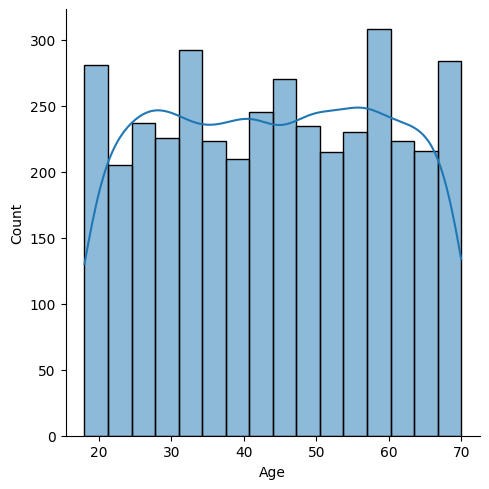

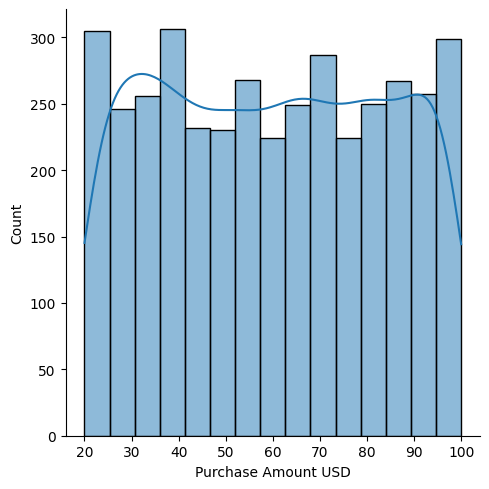

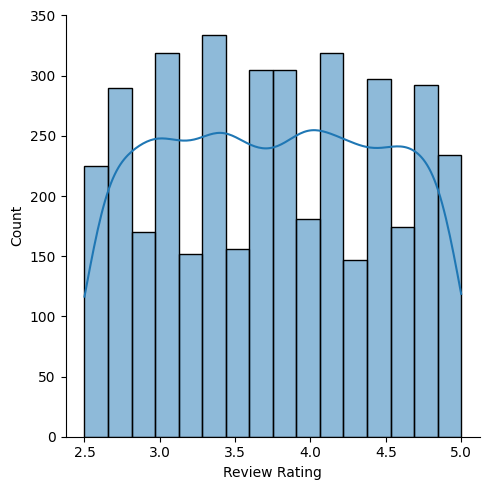

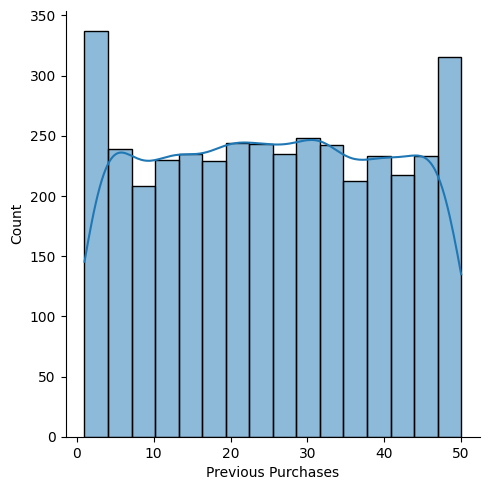

In [3]:
# distributions of continuous data :
pd.option_context('mode.use_inf_as_na', True)
sns.displot(df['Age'], kde=True)
sns.displot(df['Purchase Amount USD'], kde=True)
sns.displot(df['Review Rating'], kde=True)
sns.displot(df['Previous Purchases'], kde=True)

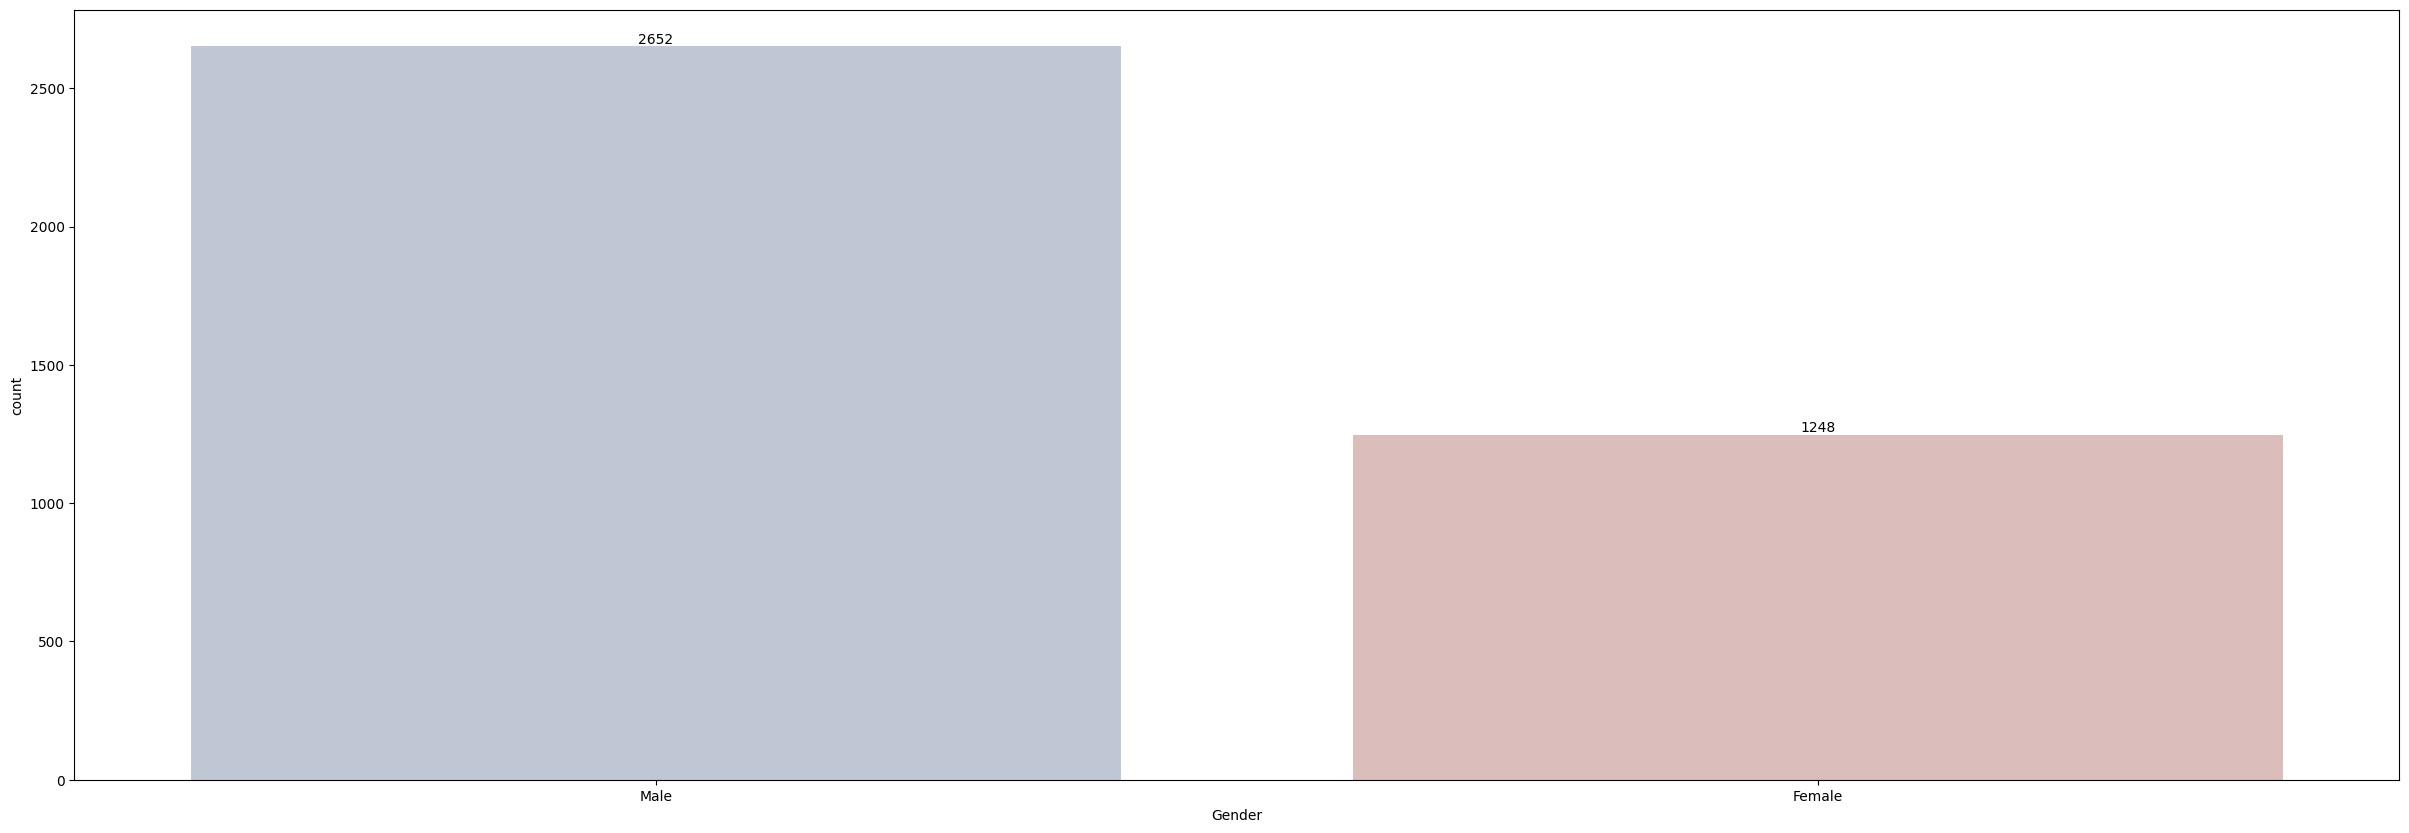

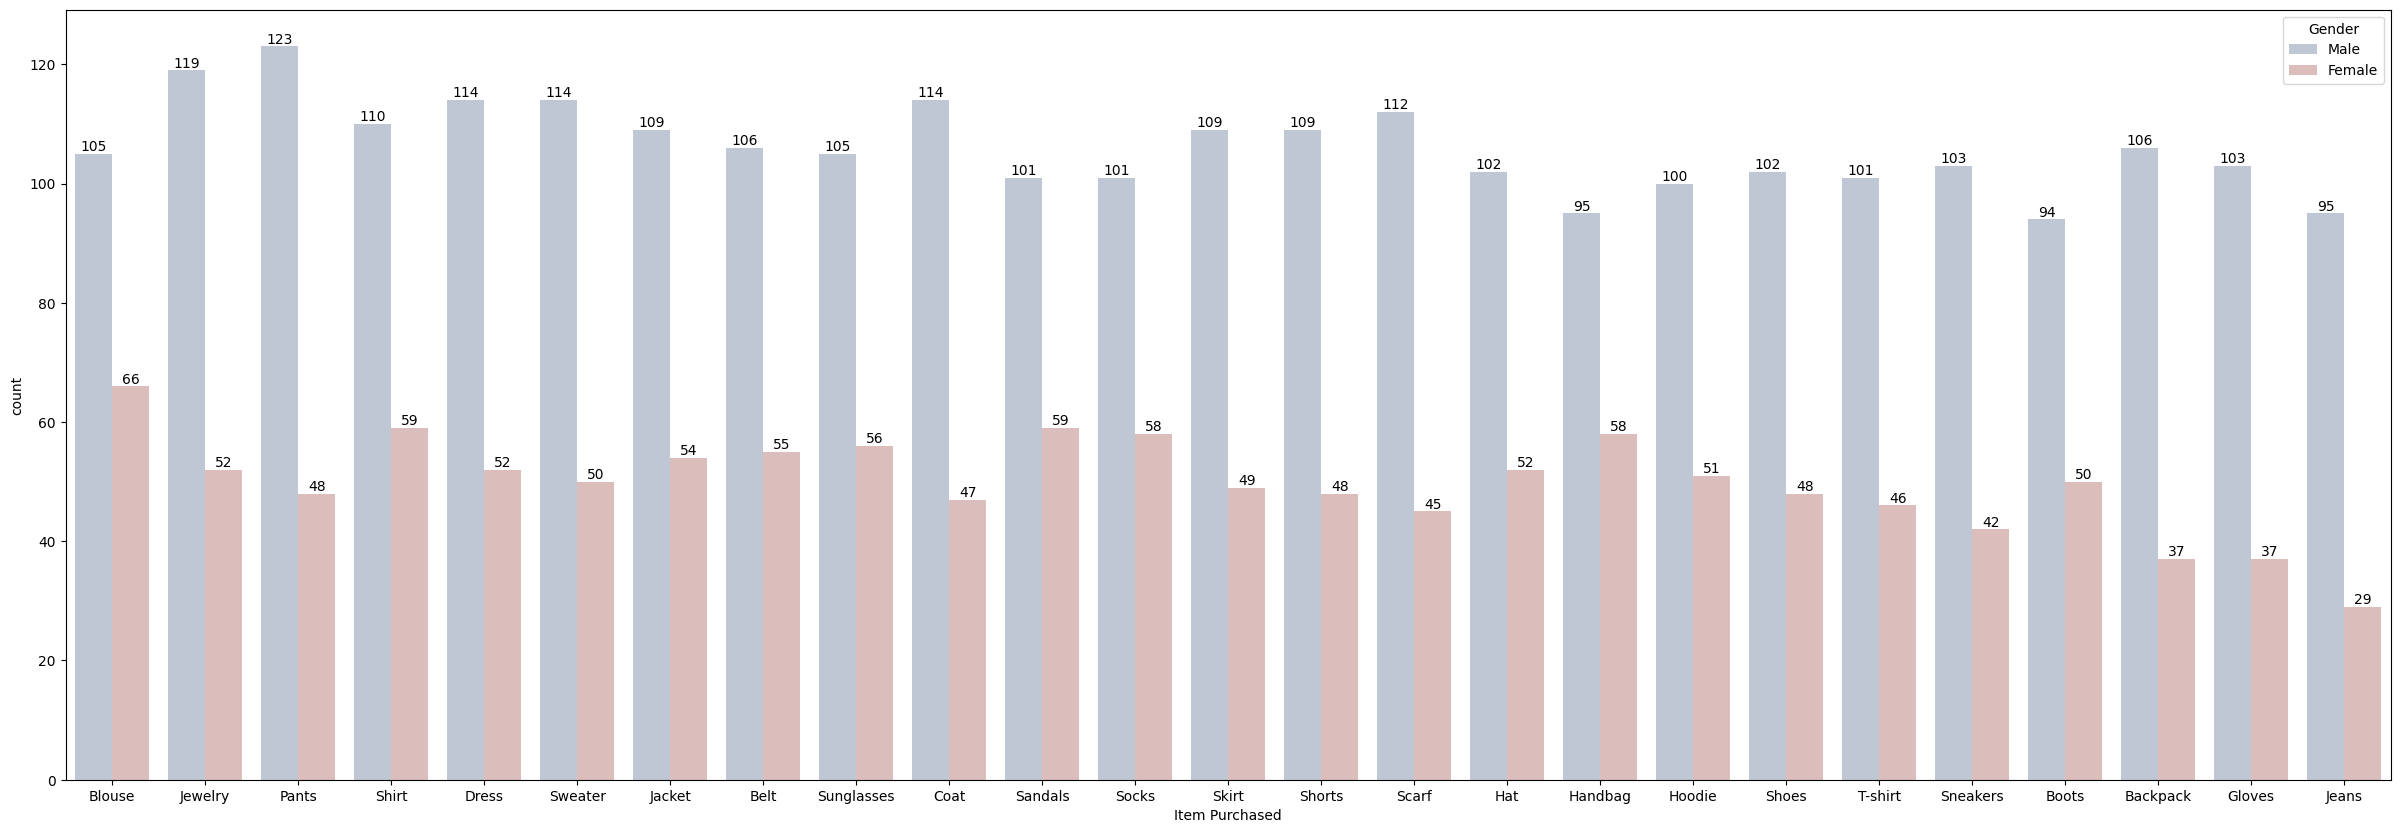

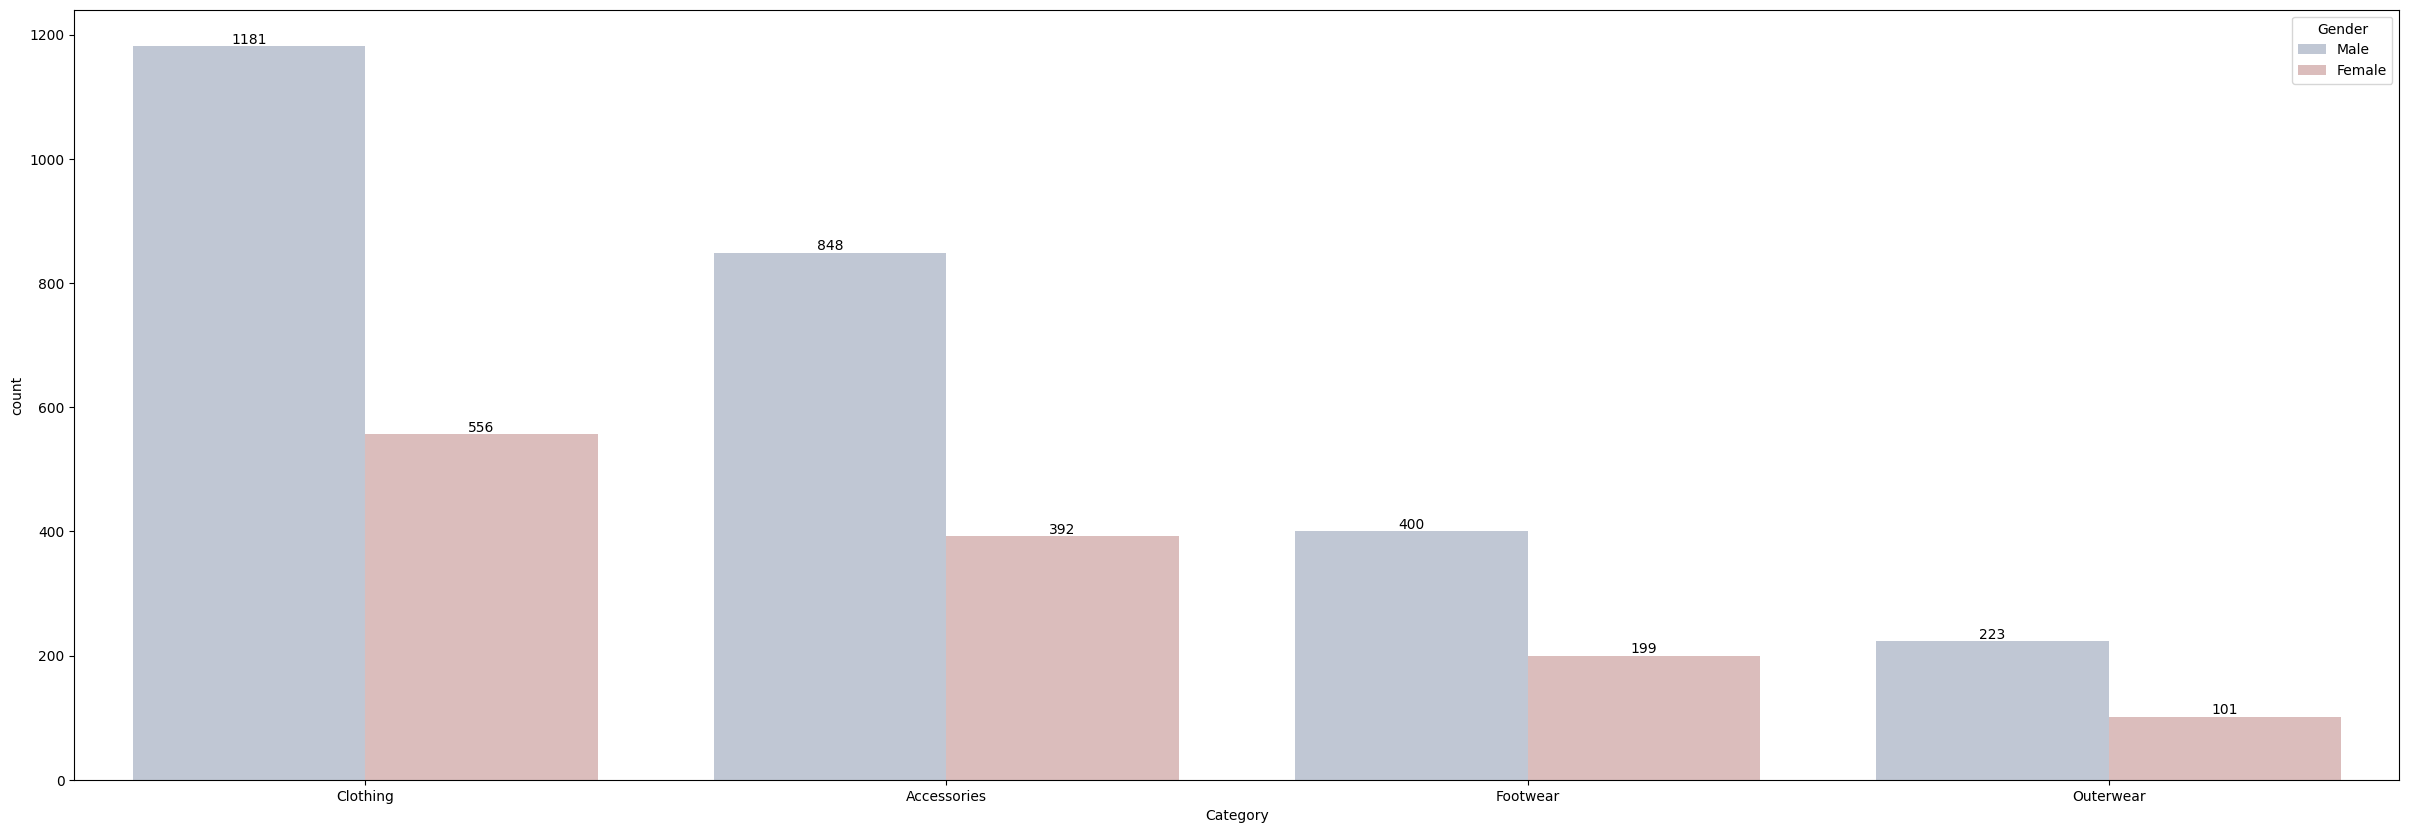

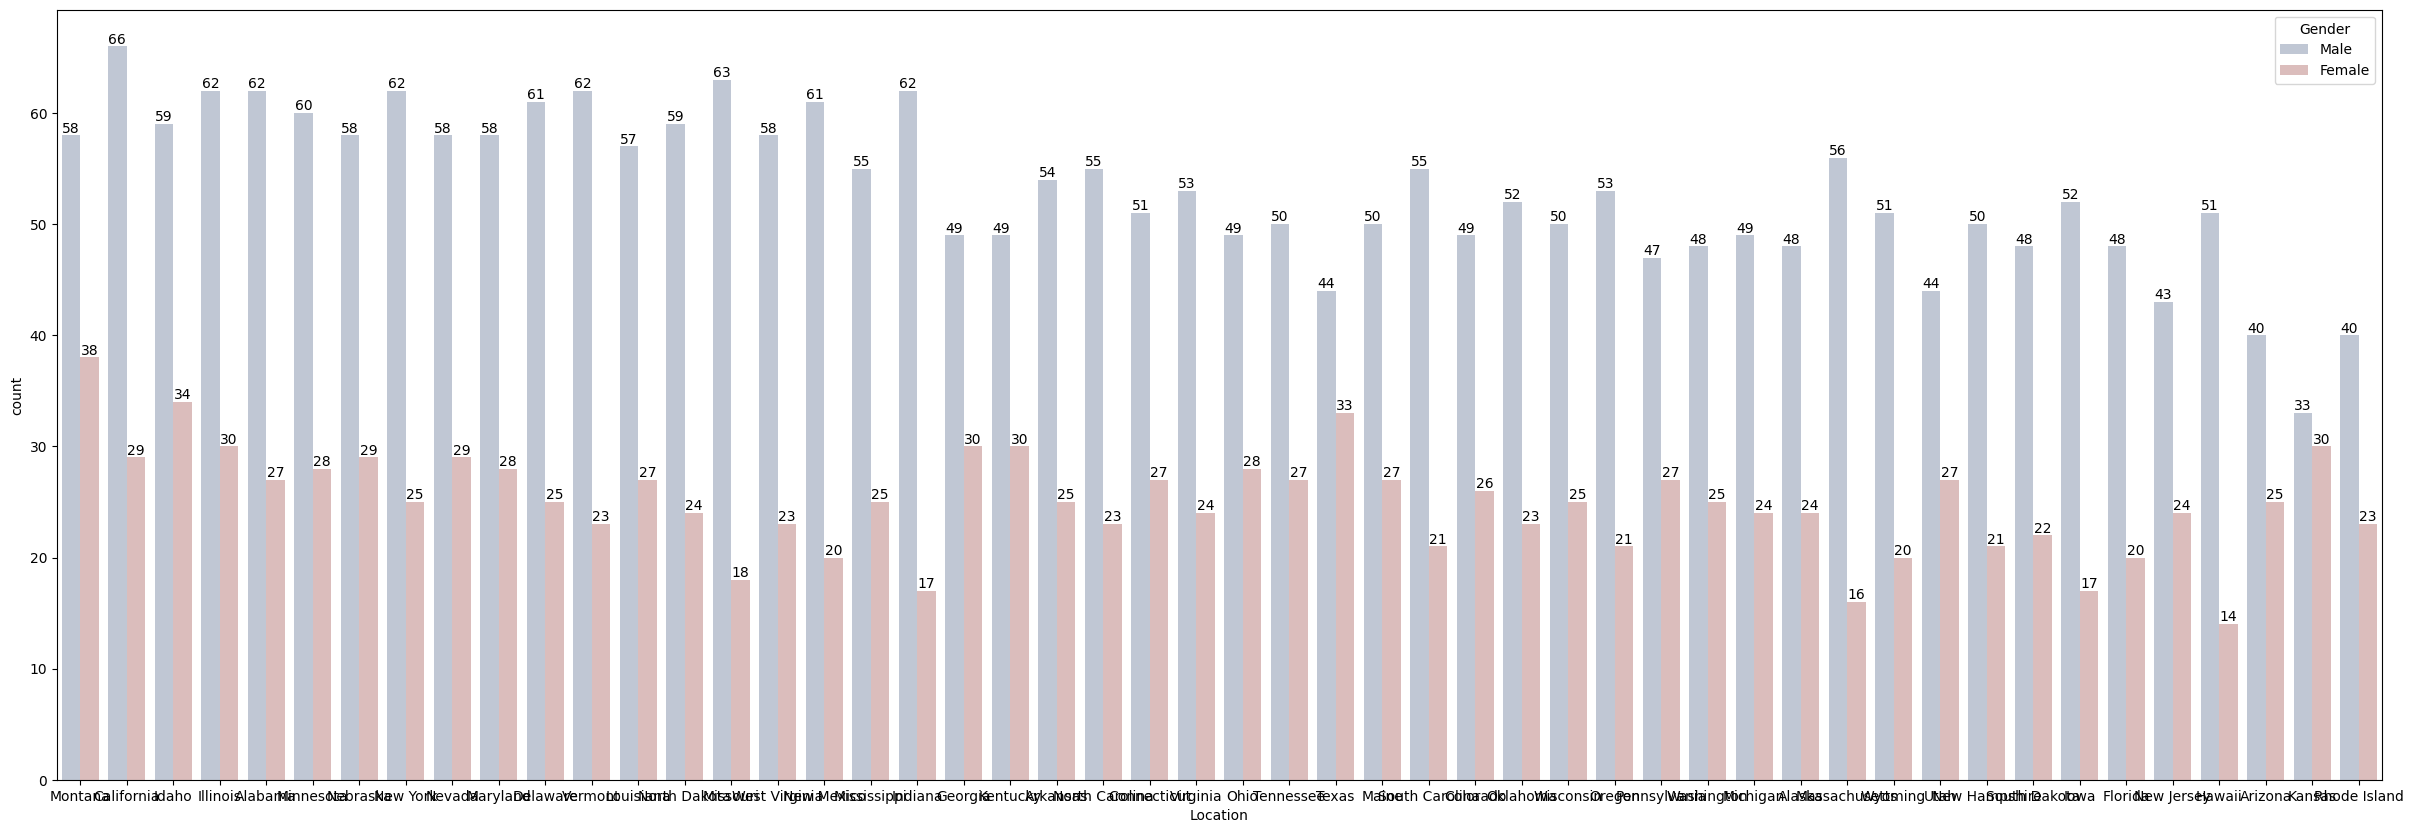

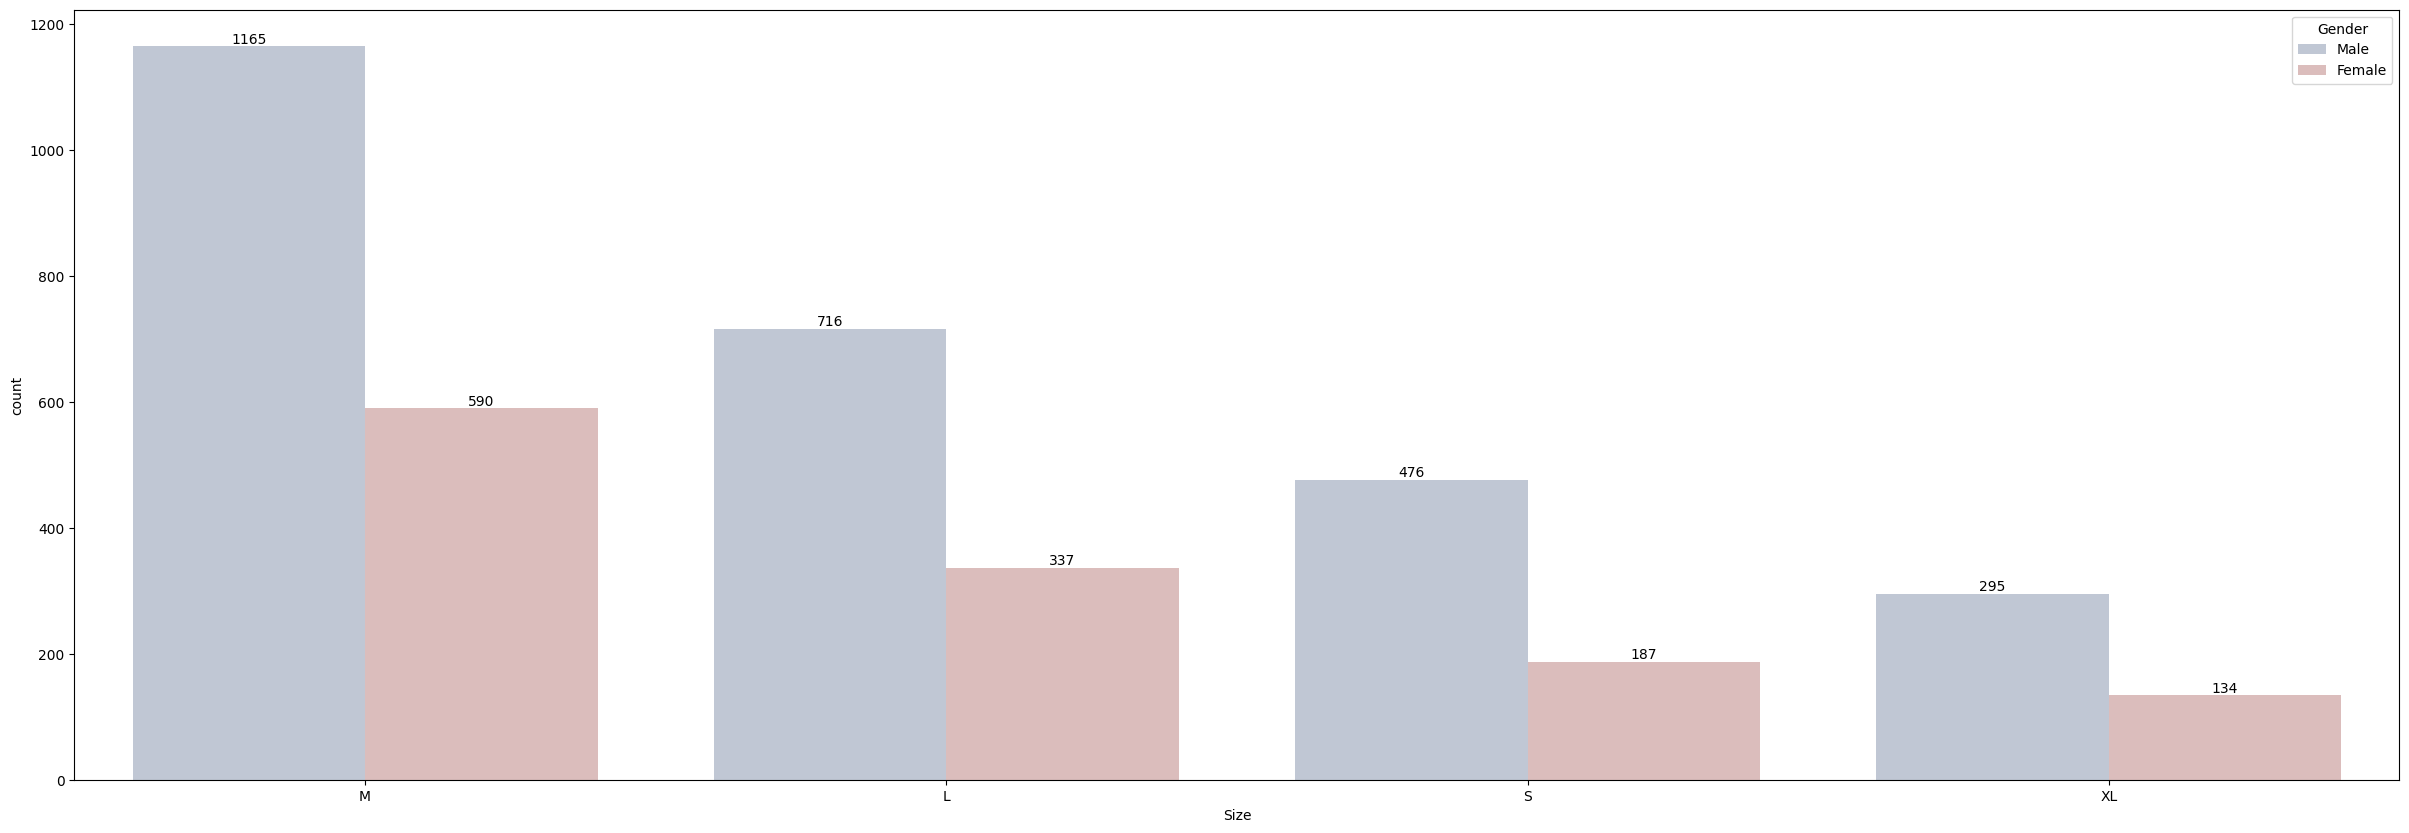

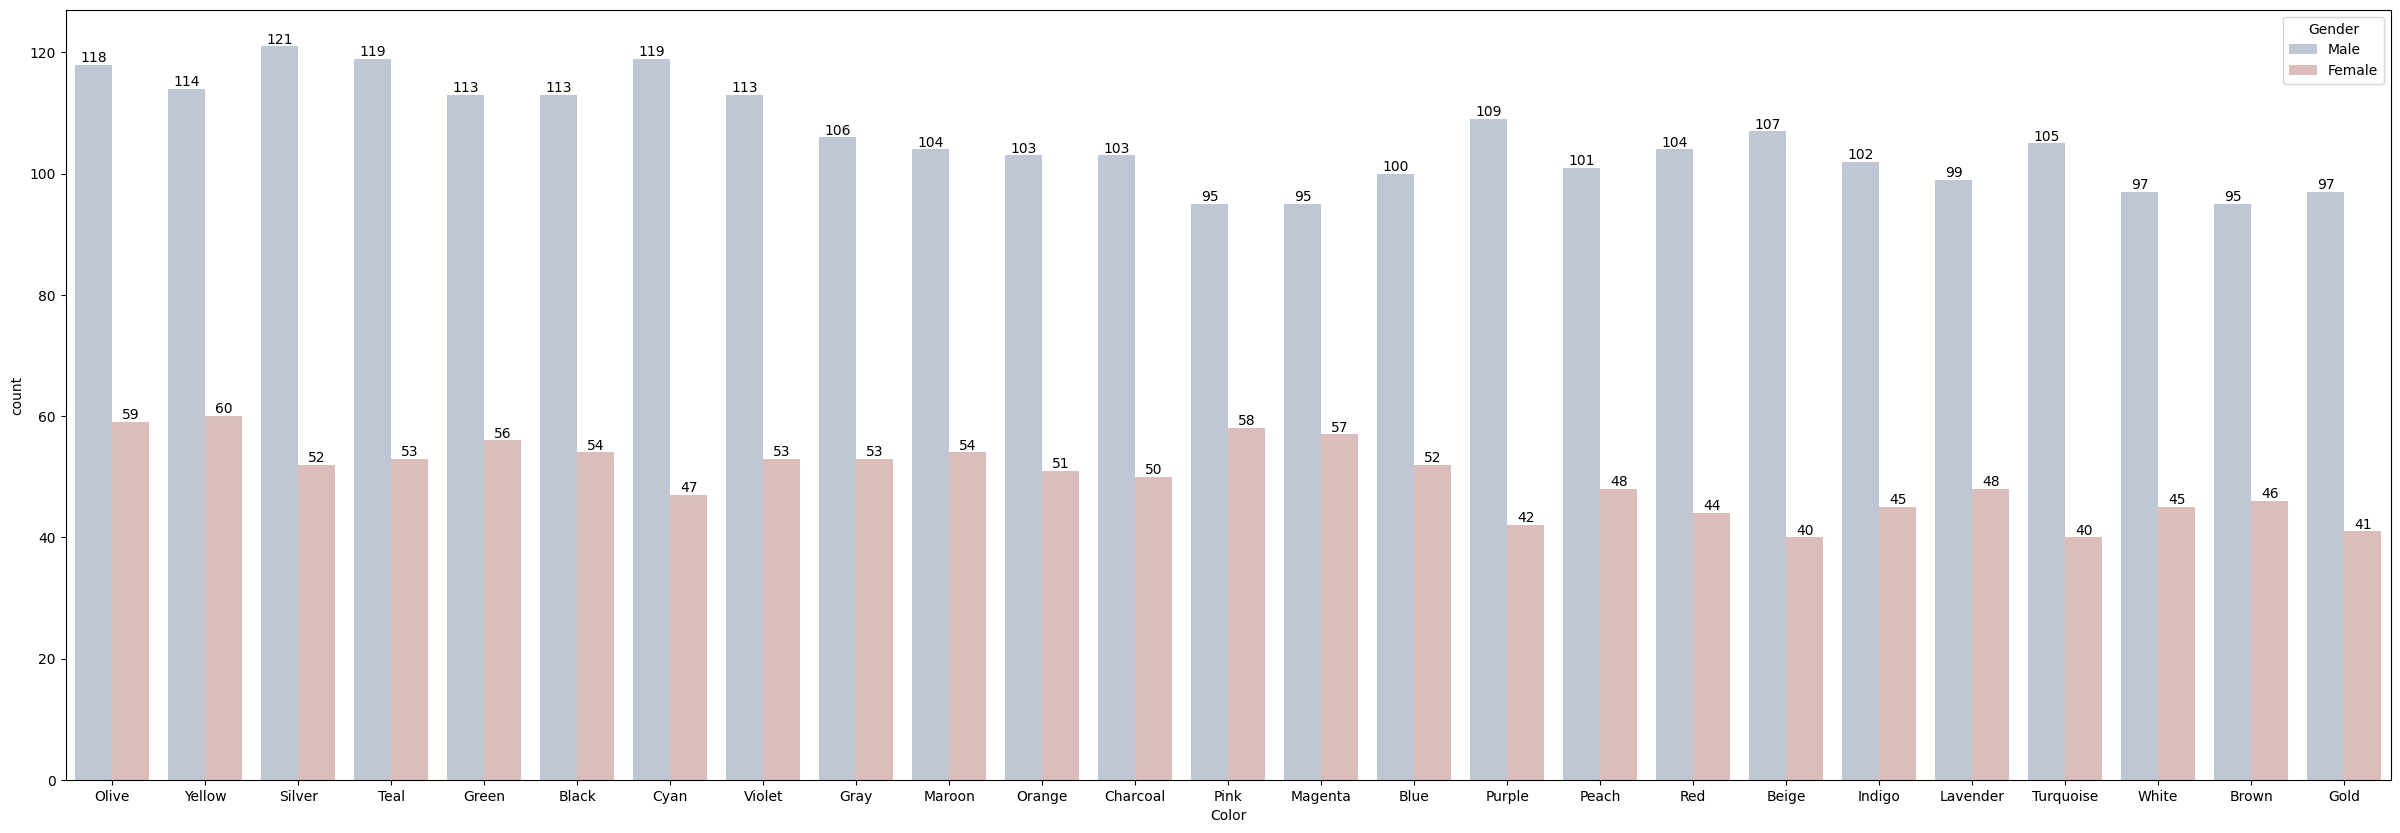

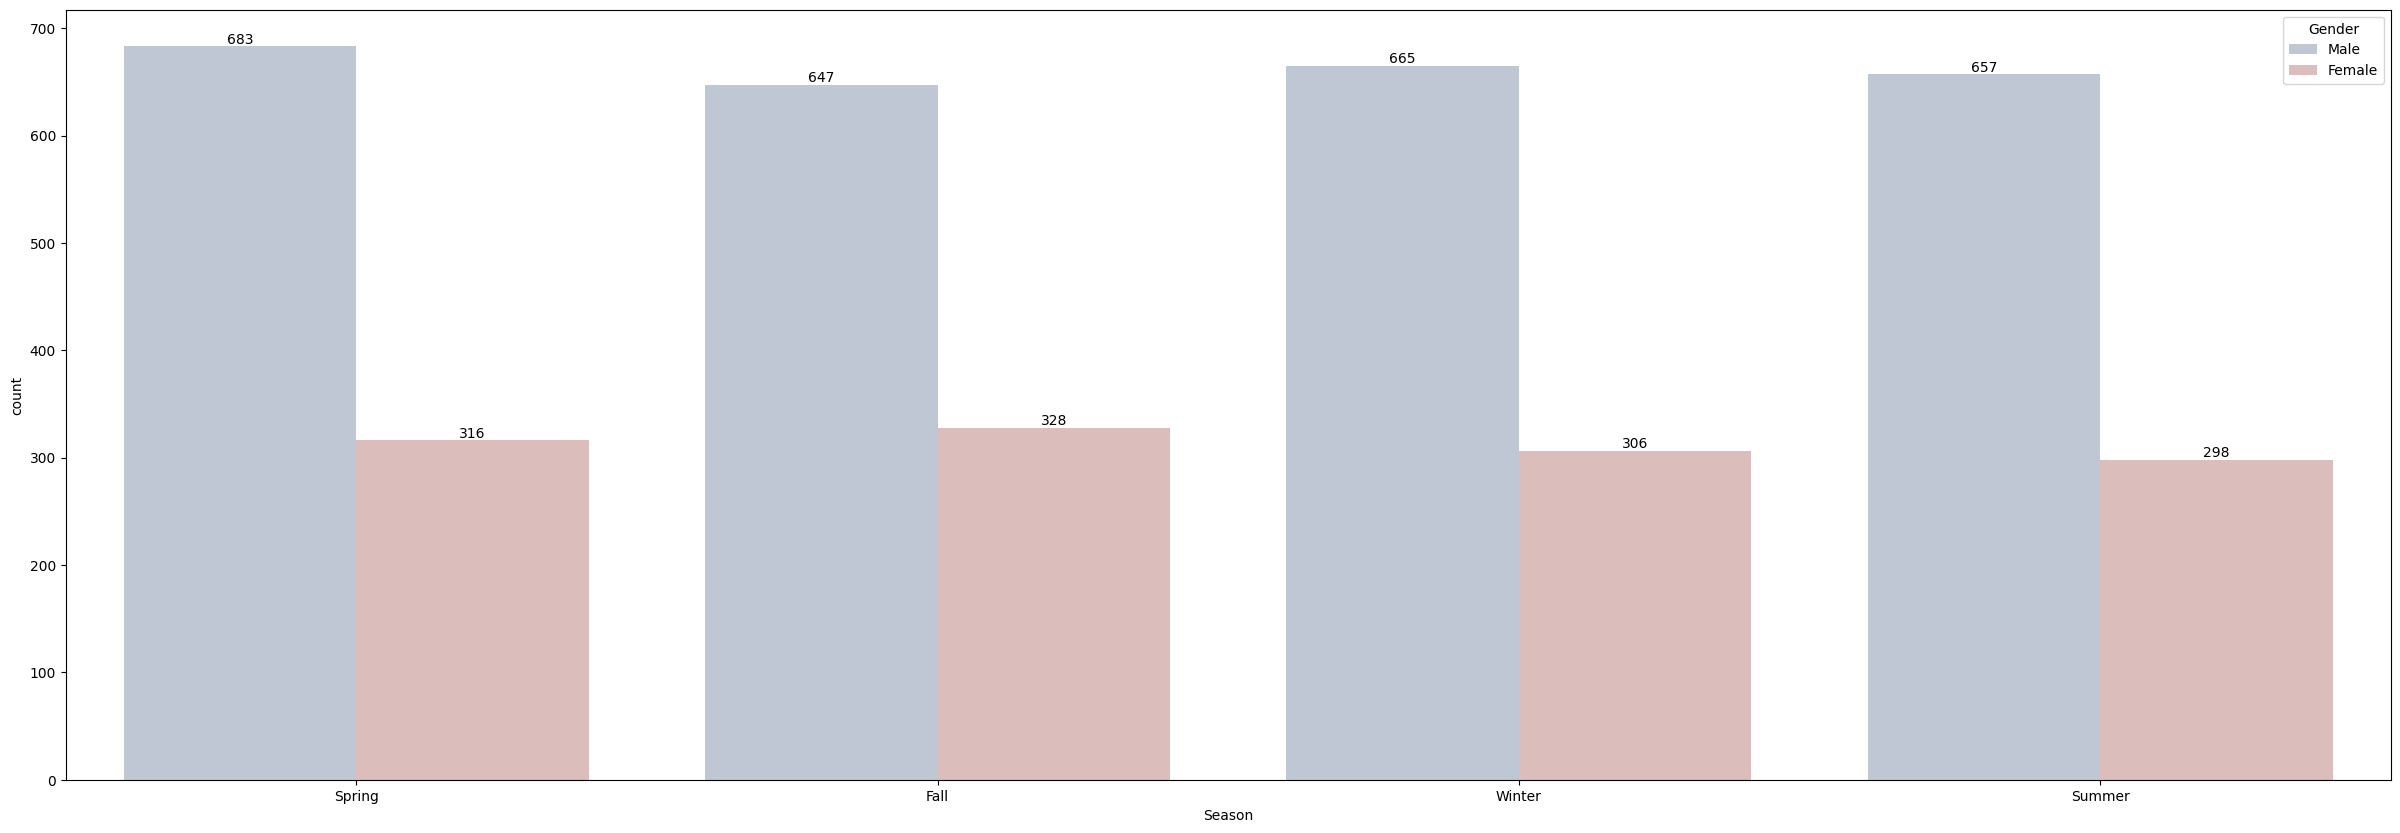

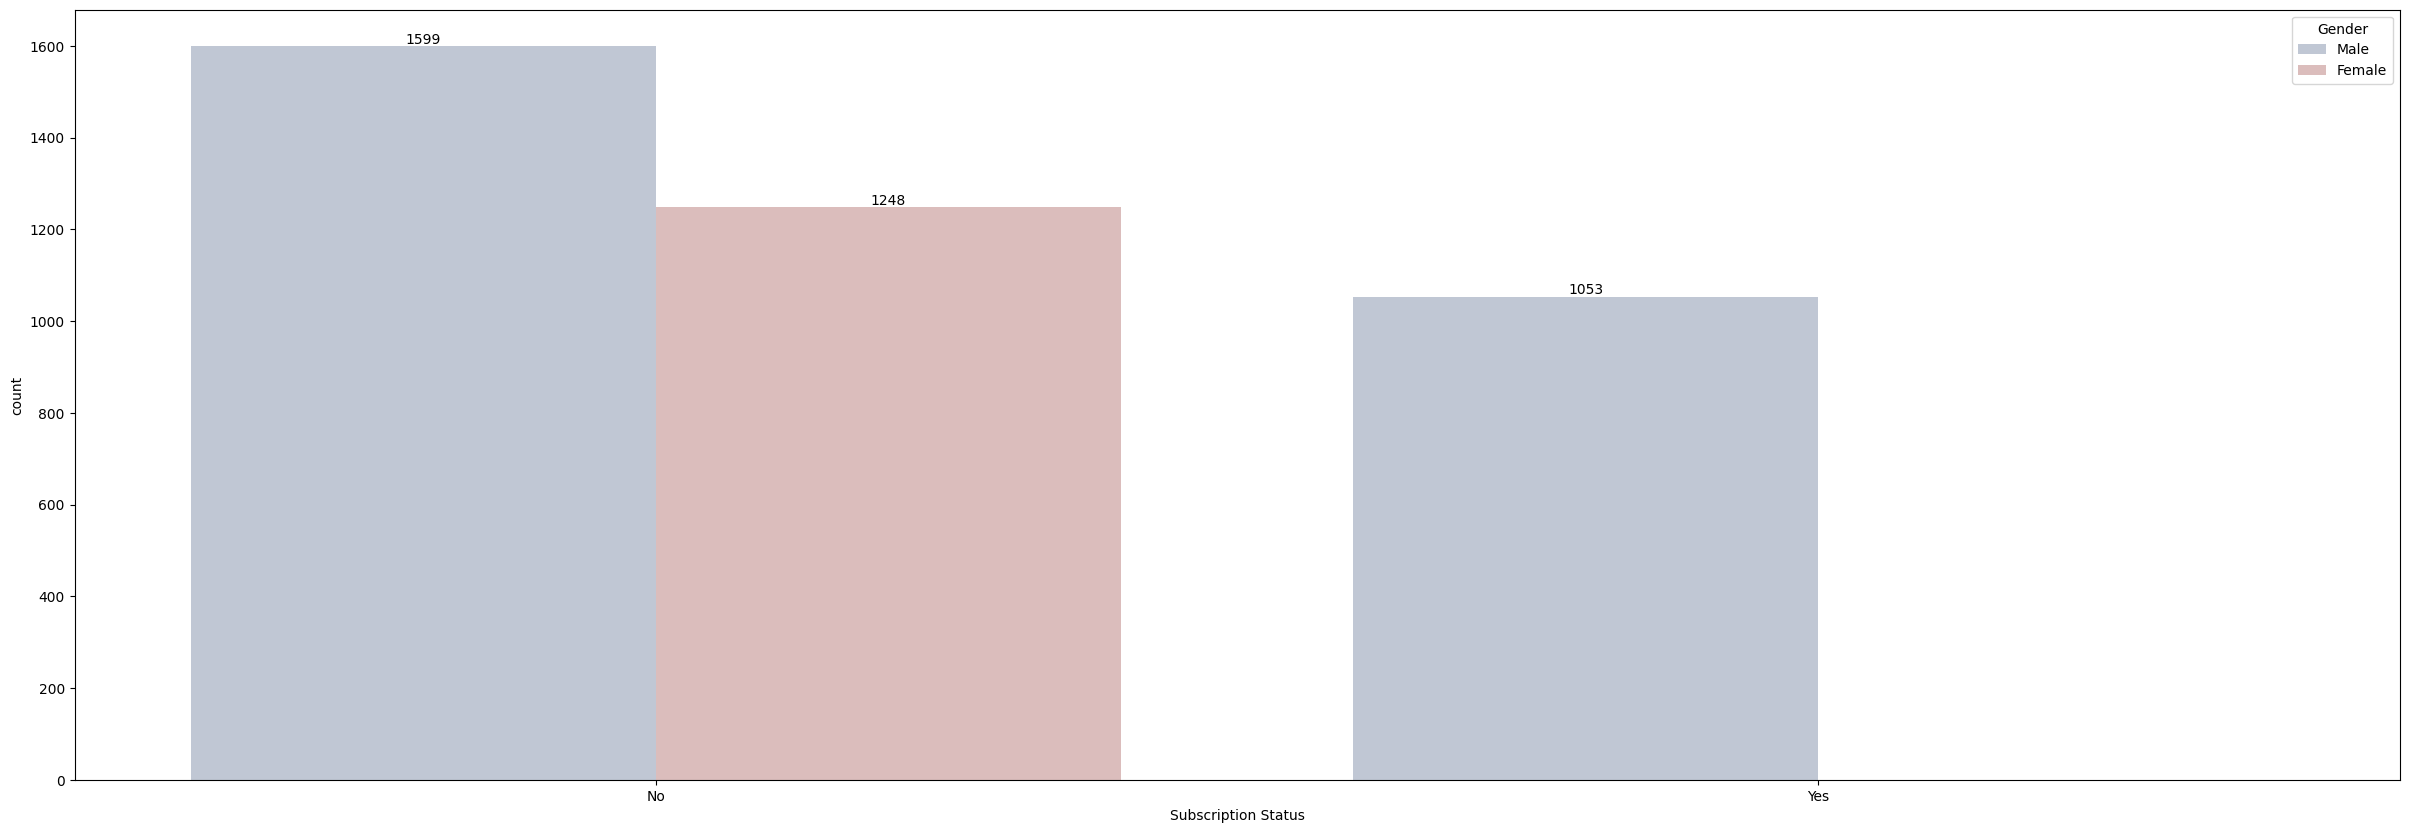

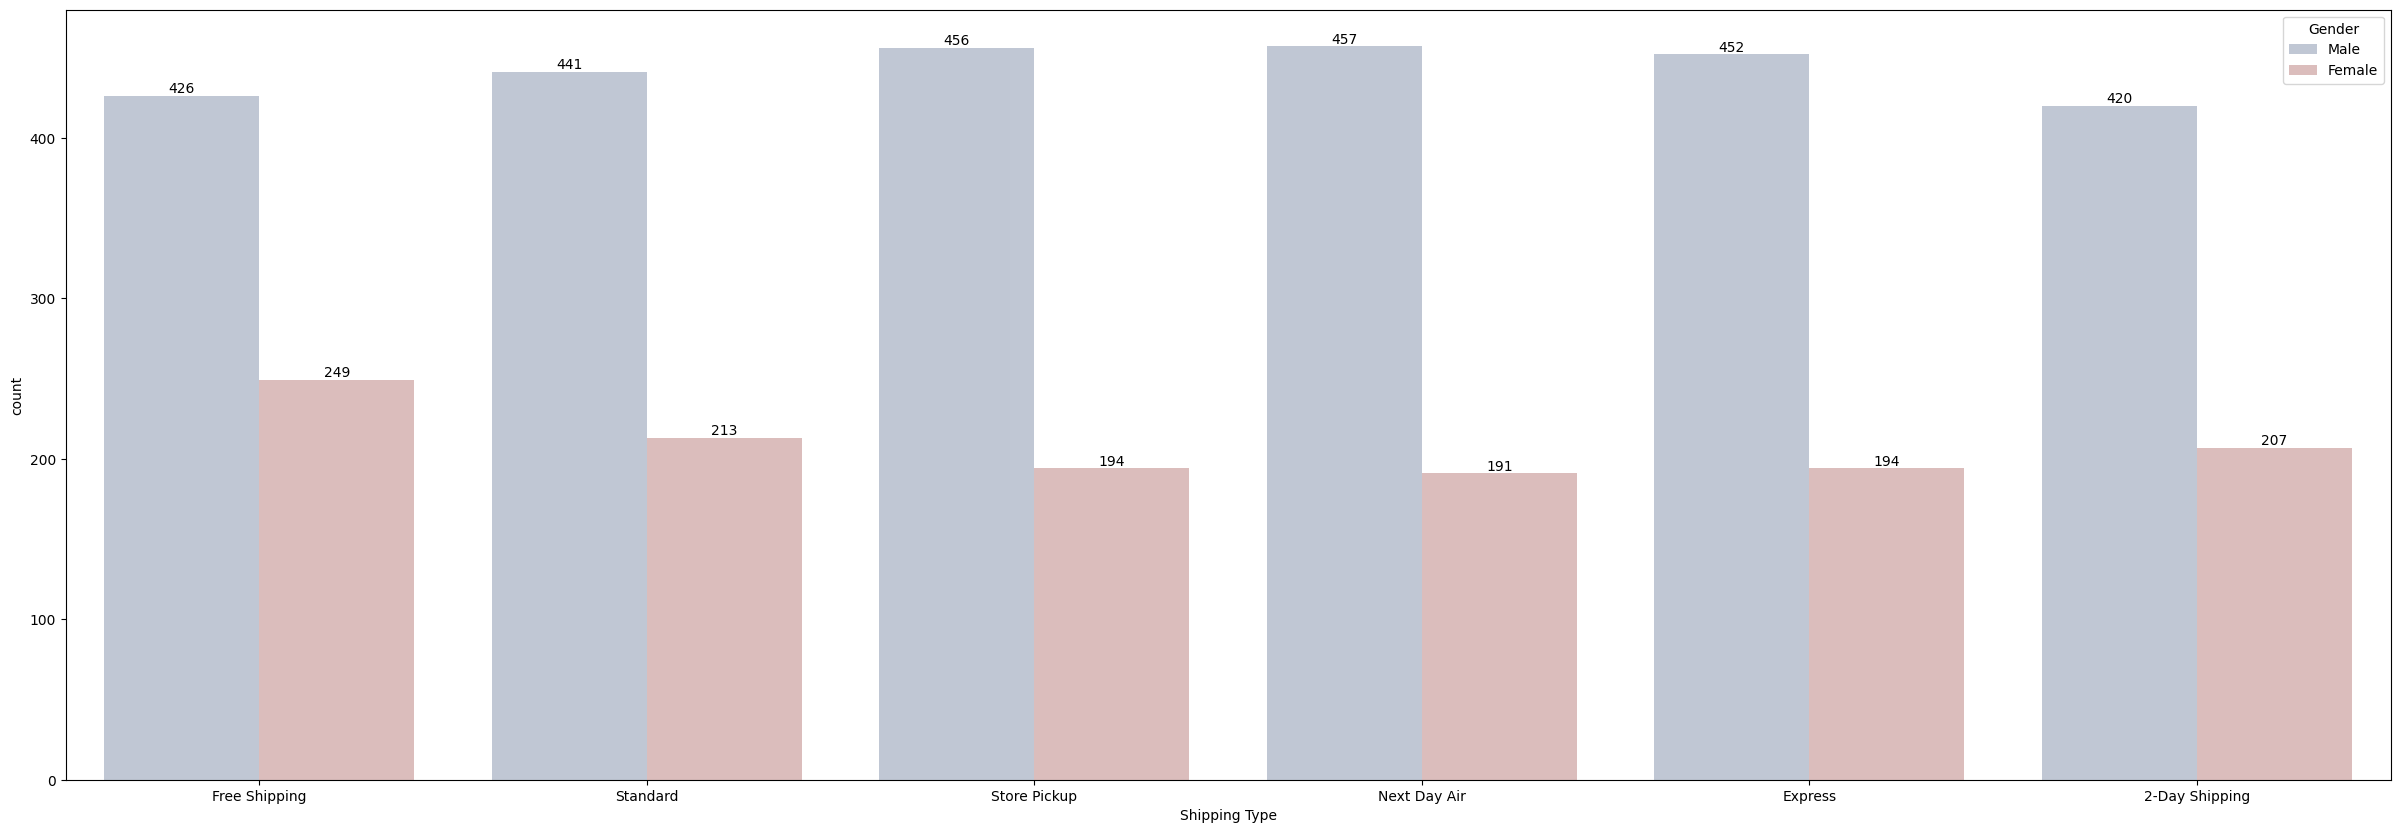

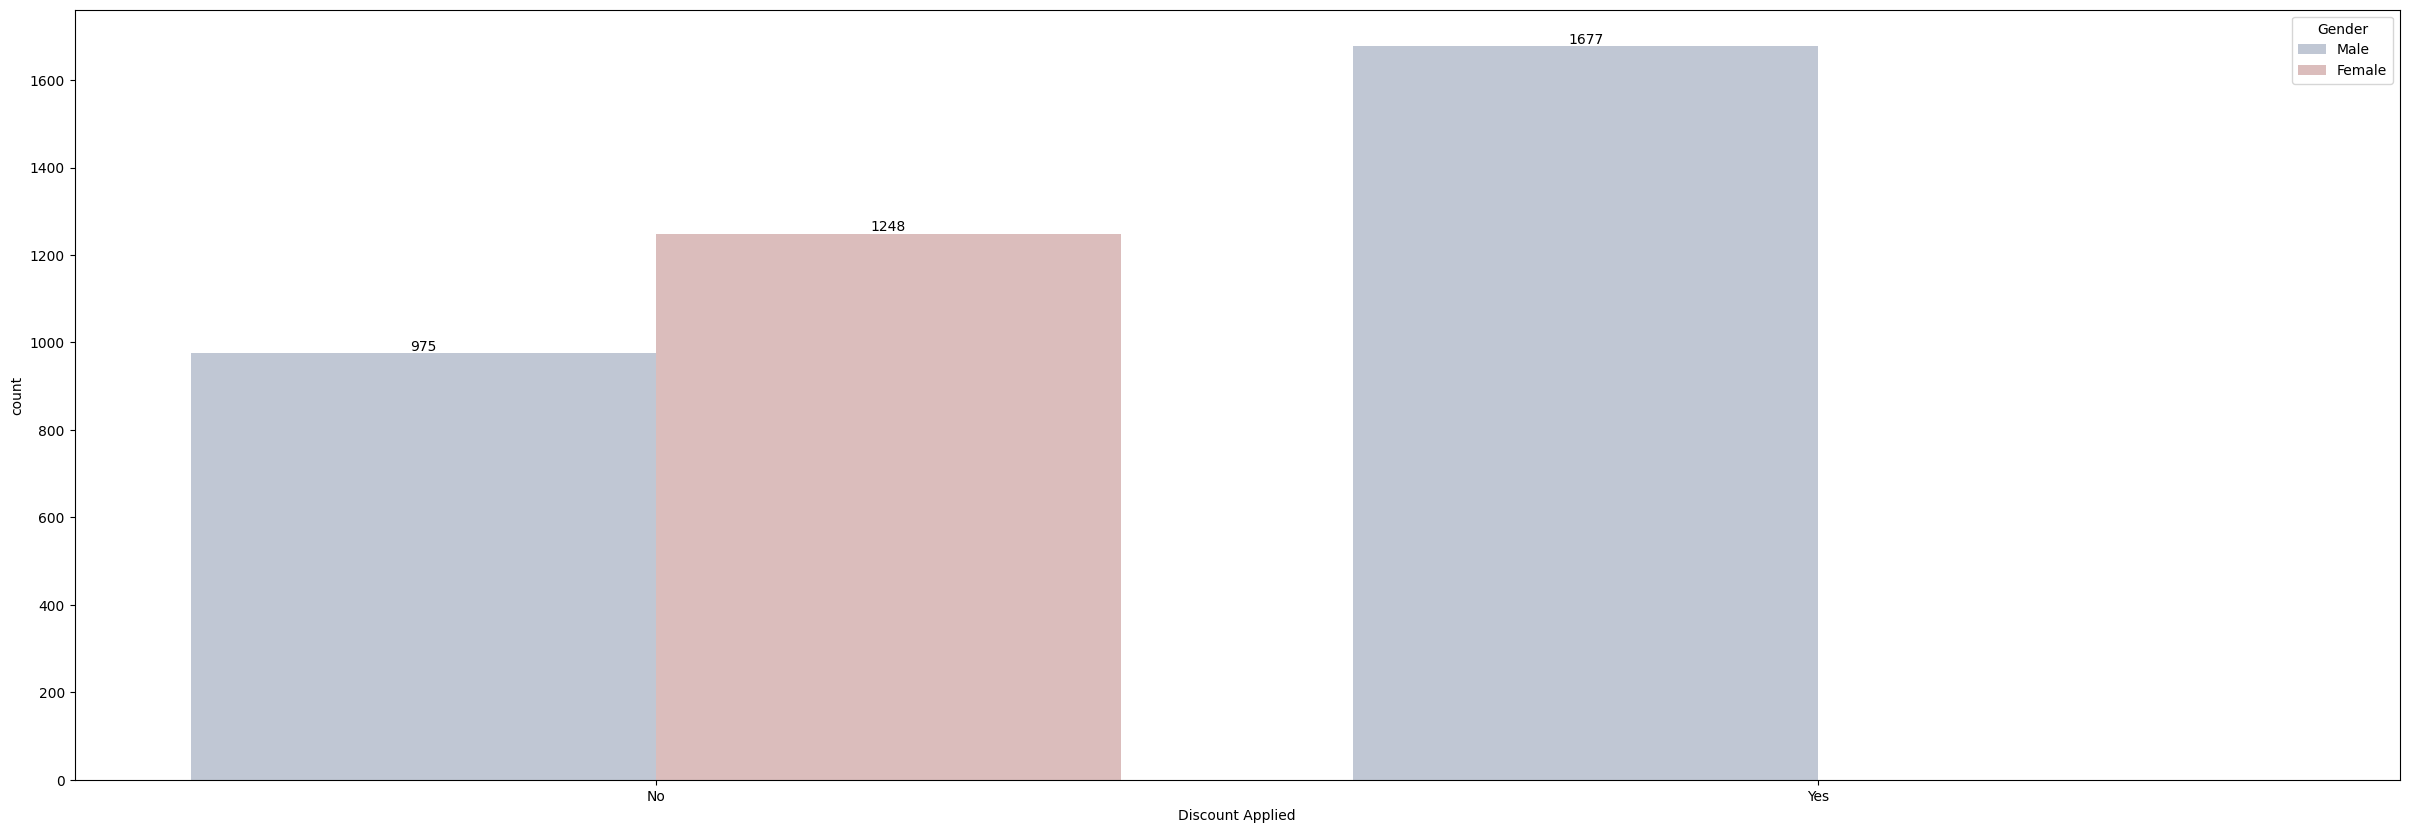

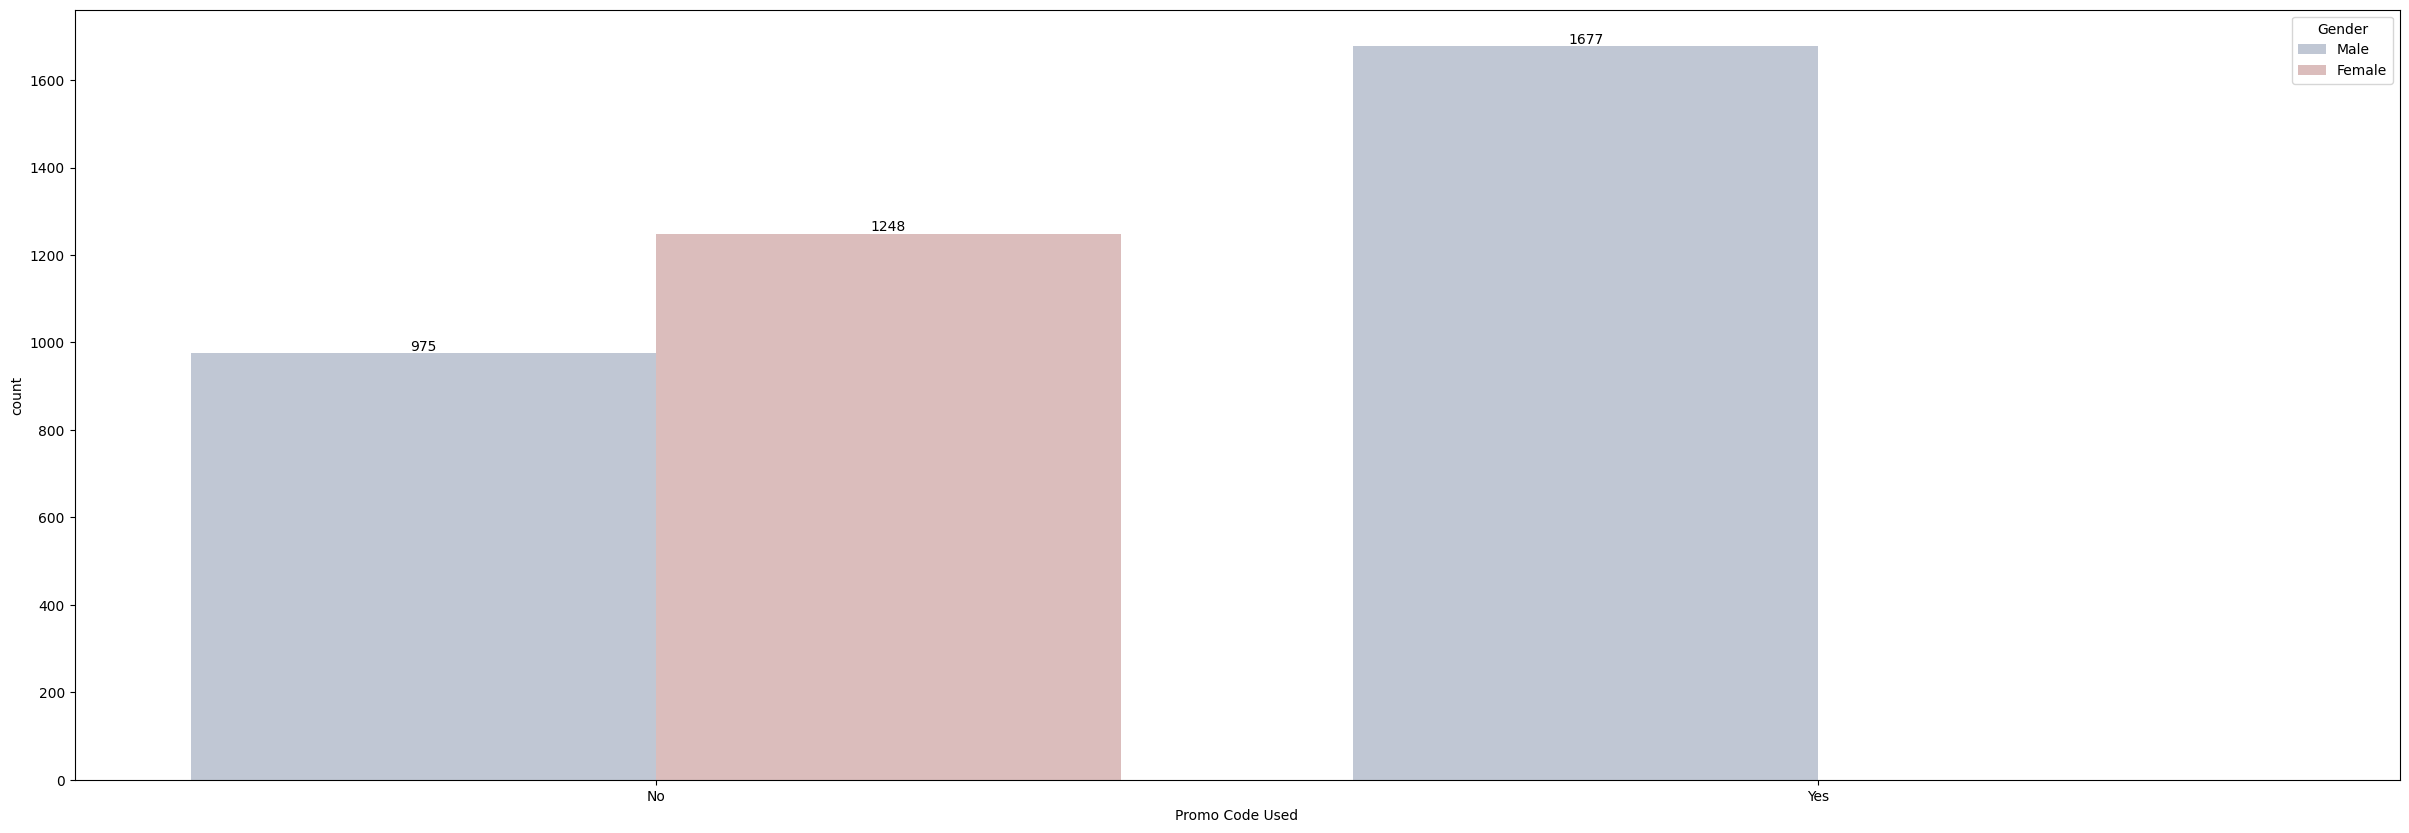

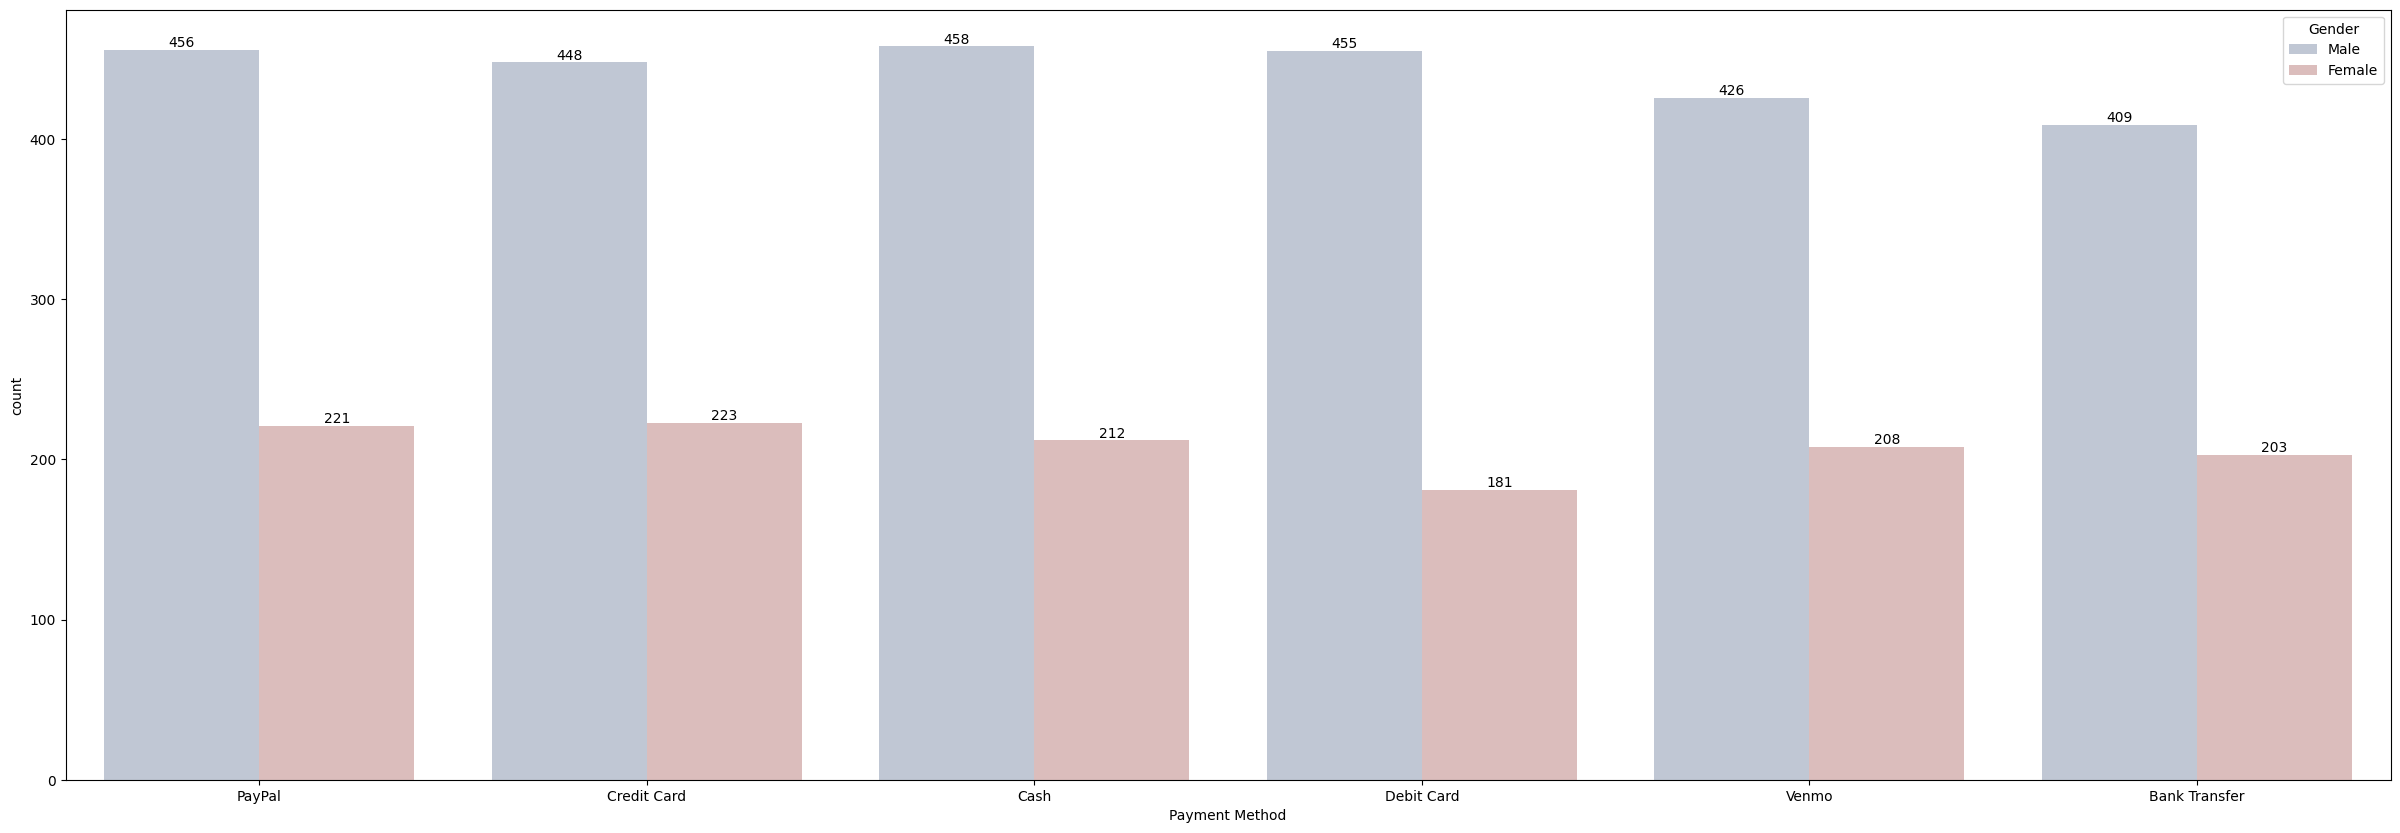

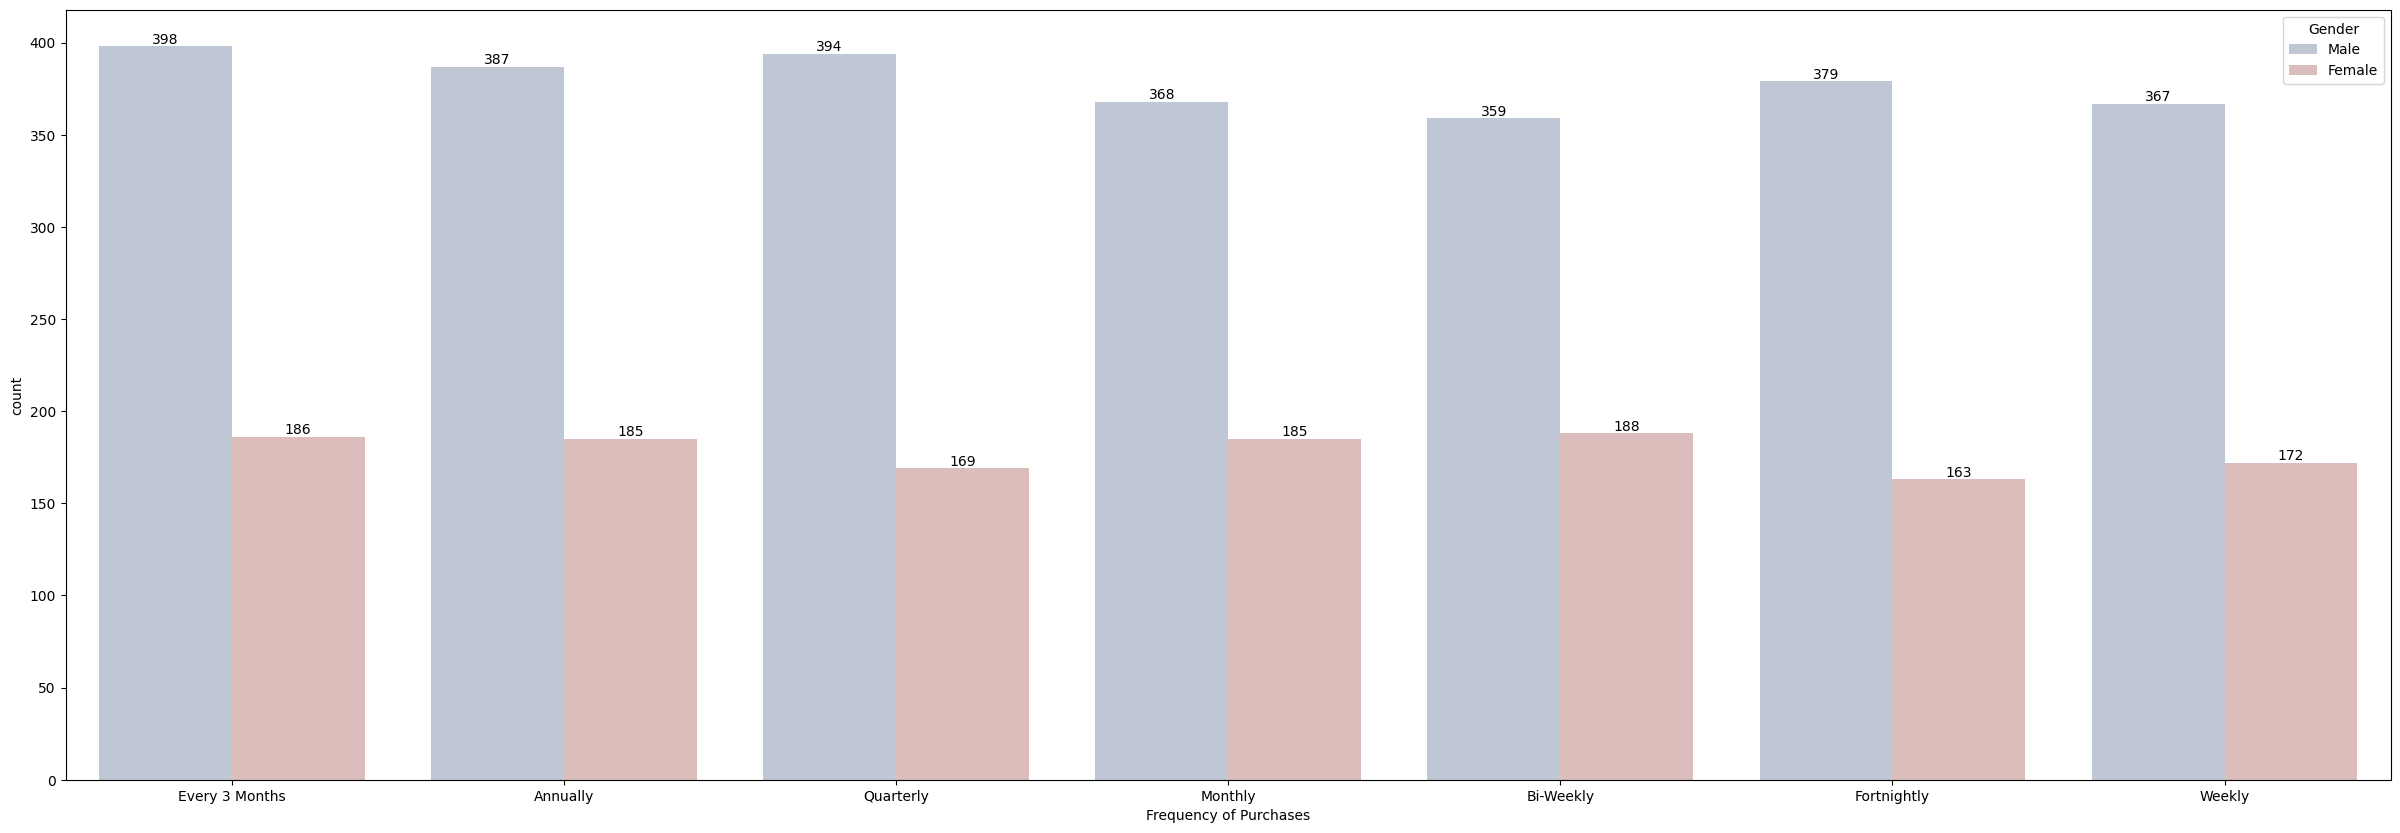

In [4]:
# numbers of categorical data :
for col in df.select_dtypes(['object']).columns:
    fig = plt.figure(figsize=(30,10))
    ax = sns.countplot(x=df[col], palette='vlag', hue=df['Gender'], order = df[col].value_counts().index)
    for container in ax.containers:
        ax.bar_label(container)
    plt.show()



<Axes: xlabel='count', ylabel='Location'>

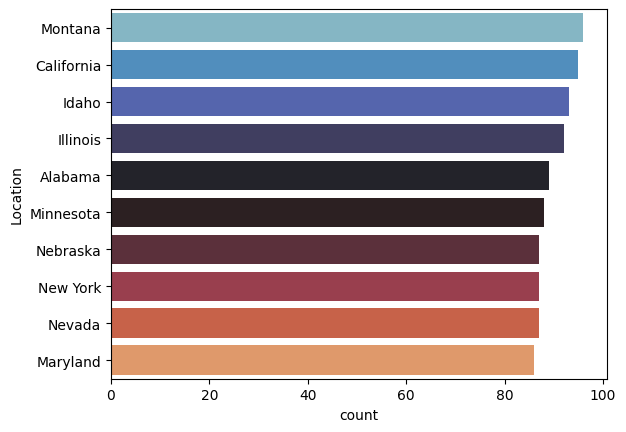

In [5]:
sns.countplot(data=df, y="Location", palette="icefire", order=df["Location"].value_counts().iloc[:10].index)

<Axes: xlabel='count', ylabel='Item Purchased'>

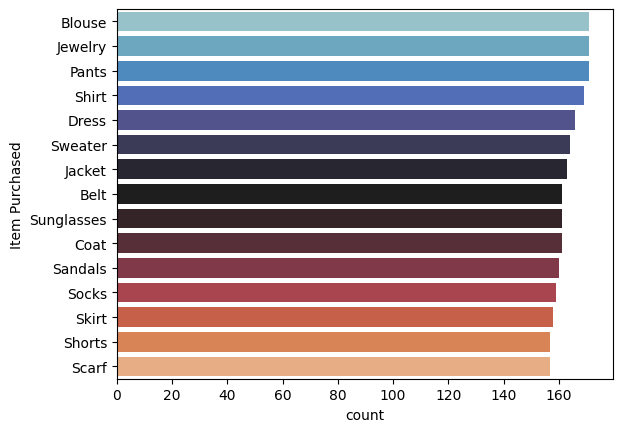

In [6]:
sns.countplot(data=df, y="Item Purchased", palette="icefire", order=df["Item Purchased"].value_counts().iloc[:15].index)

<Axes: xlabel='count', ylabel='Color'>

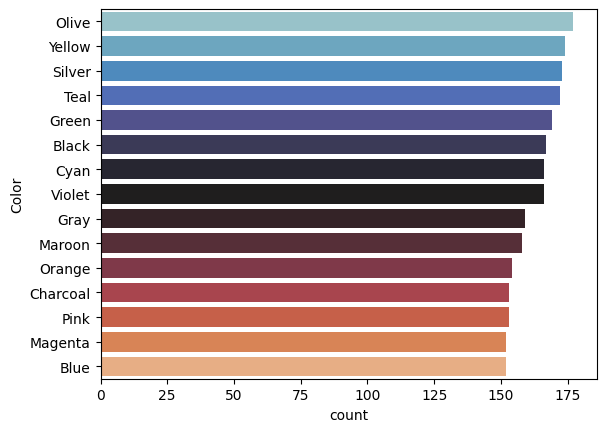

In [7]:
sns.countplot(data=df, y="Color", palette="icefire", order=df["Color"].value_counts().iloc[:15].index)

In [8]:
print(df[(df["Subscription Status"]=="No") & (df["Discount Applied"]=="Yes")]["Discount Applied"].count())
print(df[(df["Subscription Status"]=="Yes") & (df["Discount Applied"]=="Yes")]["Discount Applied"].count())

624
1053


In [9]:
# encode data to make correlations:
df.drop(columns='Customer ID', inplace=True)
encode_df = pd.get_dummies(df, columns=['Gender'], dtype=int)
encode_df['Subscription Status'] = encode_df['Subscription Status'].map({'Yes': 1, 'No': 0})
encode_df['Discount Applied'] = encode_df['Discount Applied'].map({'Yes': 1, 'No': 0})
encode_df['Promo Code Used'] = encode_df['Promo Code Used'].map({'Yes': 1, 'No': 0})

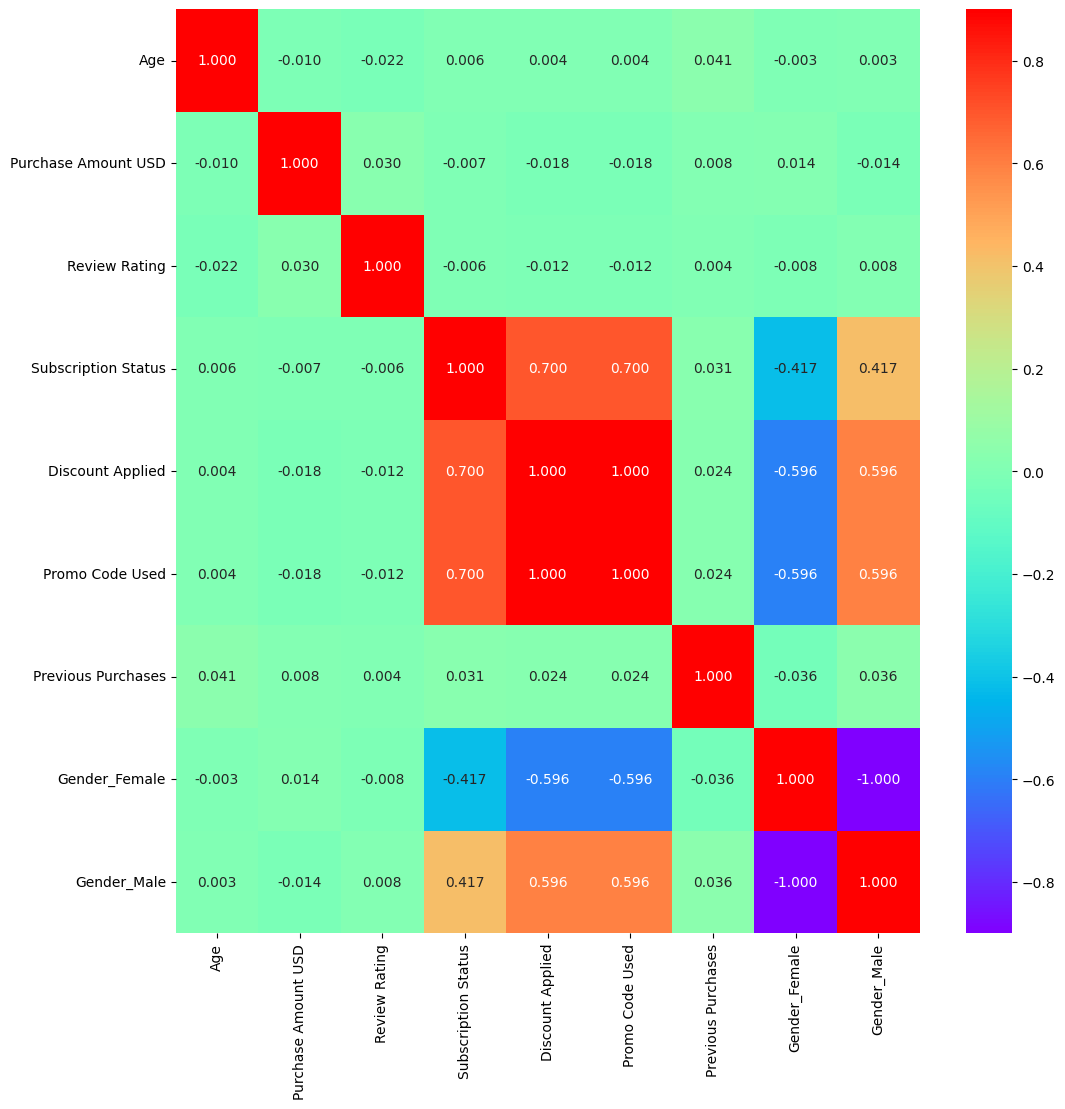

In [10]:
# spearman's correlation but discrete and binary data:
plt.subplots(figsize=(12,12))
corr_s = encode_df.corr('spearman', numeric_only=True)
sns.heatmap(corr_s, cmap="rainbow", vmin=-0.9, vmax=0.9, fmt='.3f', annot=True)
plt.show()
# columns: 'gender','subscription status', 'discount applied', 'promo code used' seem to be correlated

In [11]:
# looking for significant correlations with pvalue :
# spearman's and pointbiserial correlation :
print(encode_df[['Purchase Amount USD', 'Previous Purchases', 'Age', 'Review Rating']].corrwith(encode_df['Subscription Status'].astype('float'), method=stats.pointbiserialr))
print(encode_df[['Purchase Amount USD', 'Previous Purchases', 'Age', 'Review Rating']].corrwith(encode_df['Gender_Male'].astype('float'), method=stats.pointbiserialr))
print(encode_df[['Purchase Amount USD', 'Previous Purchases', 'Age', 'Review Rating']].corrwith(encode_df['Gender_Female'].astype('float'), method=stats.pointbiserialr))
print(encode_df[['Purchase Amount USD', 'Previous Purchases', 'Age', 'Review Rating']].corrwith(encode_df['Discount Applied'].astype('float'), method=stats.pointbiserialr))
print(encode_df[['Purchase Amount USD', 'Previous Purchases', 'Age', 'Review Rating']].corrwith(encode_df['Promo Code Used'].astype('float'), method=stats.pointbiserialr))
print(stats.spearmanr(encode_df['Age'], encode_df['Purchase Amount USD']).pvalue)
print(stats.spearmanr(encode_df['Age'], encode_df['Review Rating']).pvalue)
print(stats.spearmanr(encode_df['Age'], encode_df['Previous Purchases']))
print(stats.spearmanr(encode_df['Purchase Amount USD'], encode_df['Previous Purchases']))
print(stats.spearmanr(encode_df['Purchase Amount USD'], encode_df['Review Rating']))
print(stats.spearmanr(encode_df['Previous Purchases'], encode_df['Review Rating']))

   Purchase Amount USD  Previous Purchases       Age  Review Rating
0            -0.006996            0.030859  0.006492      -0.006368
1             0.662280            0.053978  0.685274       0.690954
   Purchase Amount USD  Previous Purchases       Age  Review Rating
0            -0.014044            0.035873  0.002763       0.008164
1             0.380587            0.025075  0.863036       0.610280
   Purchase Amount USD  Previous Purchases       Age  Review Rating
0             0.014044           -0.035873 -0.002763      -0.008164
1             0.380587            0.025075  0.863036       0.610280
   Purchase Amount USD  Previous Purchases       Age  Review Rating
0            -0.017798            0.023537  0.004366      -0.012486
1             0.266474            0.141664  0.785169       0.435678
   Purchase Amount USD  Previous Purchases       Age  Review Rating
0            -0.017798            0.023537  0.004366      -0.012486
1             0.266474            0.141664  0.78

                          Age  Gender  Item Purchased  Category  \
Age                     1.000   0.127           0.118     0.123   
Gender                  0.127   0.999           0.079     0.012   
Item Purchased          0.118   0.079           1.000     1.000   
Category                0.123   0.012           1.000     1.000   
Purchase Amount USD     0.140   0.126           0.136     0.130   
Location                0.120   0.109           0.110     0.103   
Size                    0.117   0.041           0.072     0.028   
Color                   0.116   0.057           0.079     0.079   
Season                  0.116   0.021           0.082     0.026   
Review Rating           0.114   0.069           0.082     0.084   
Subscription Status     0.110   0.417           0.080     0.019   
Shipping Type           0.119   0.056           0.078     0.029   
Discount Applied        0.113   0.595           0.090     0.018   
Promo Code Used         0.113   0.595           0.090     0.01

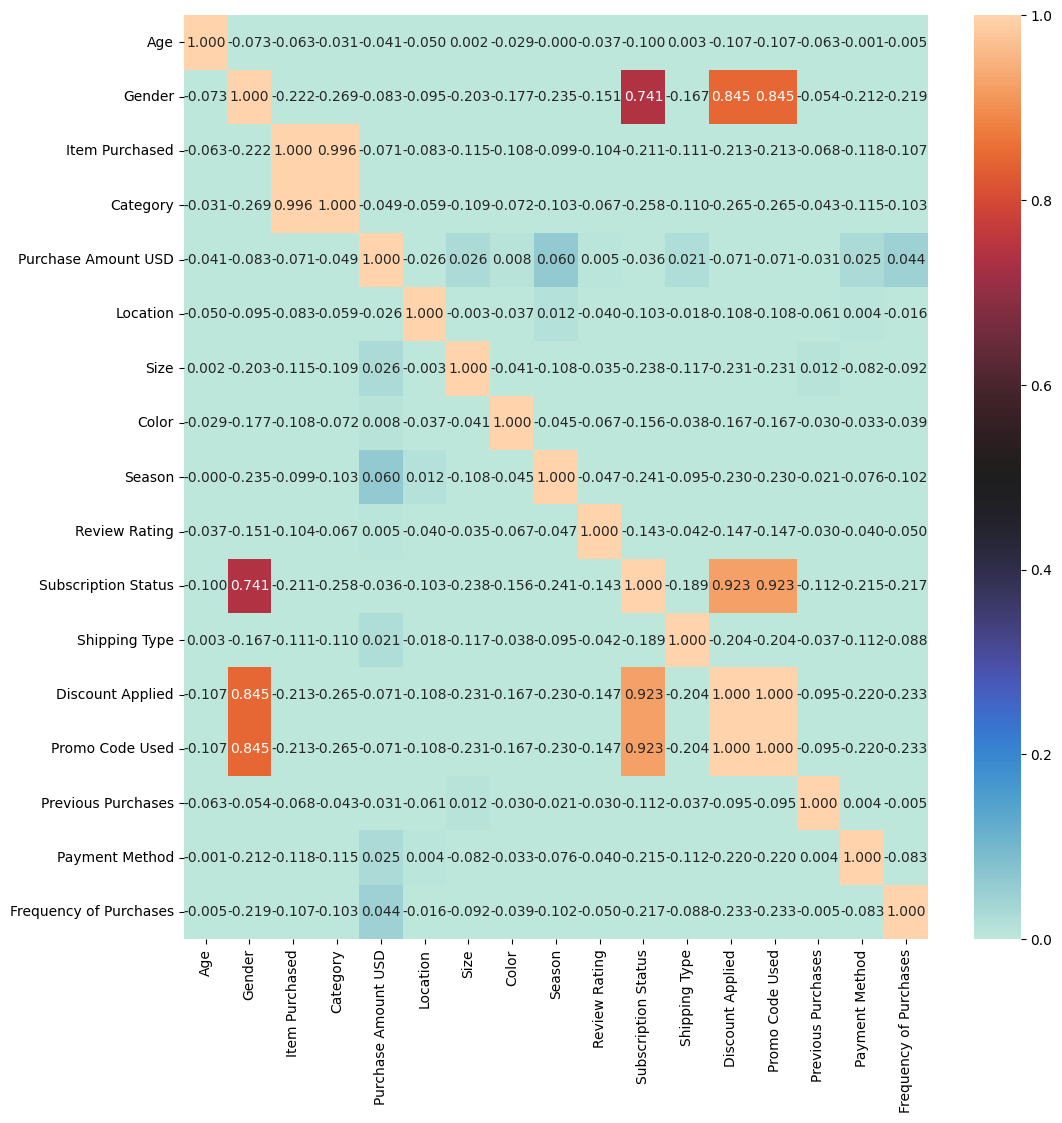

                             Age    Gender  Item Purchased      Category  \
Age                     0.000000  0.781930    8.090101e-01  9.072108e-01   
Gender                  0.781930  0.000000    3.921346e-01  2.962059e-01   
Item Purchased          0.809010  0.392135    0.000000e+00  2.136170e-17   
Category                0.907211  0.296206    2.136170e-17  0.000000e+00   
Purchase Amount USD     0.876013  0.751187    7.856741e-01  8.519146e-01   
Location                0.847735  0.715444    7.510503e-01  8.217145e-01   
Size                    0.995040  0.435351    6.590902e-01  6.782300e-01   
Color                   0.911659  0.495880    6.797724e-01  7.826263e-01   
Season                  0.999151  0.363641    7.046982e-01  6.947385e-01   
Review Rating           0.888372  0.562592    6.924982e-01  7.976018e-01   
Subscription Status     0.703820  0.000674    4.153668e-01  3.175728e-01   
Shipping Type           0.990823  0.521081    6.723786e-01  6.735310e-01   
Discount App

In [12]:
# now focus on categorical data :

# encode categorical data:
encoder = OrdinalEncoder()
encoded_df2 = df.copy()

encoded_df2['Gender'] = encoded_df2['Gender'].map({'Male': 1.0, 'Female': 0.0})
encoded_df2['Subscription Status'] = encoded_df2['Subscription Status'].map({'Yes': 1.0, 'No': 0.0})
encoded_df2['Discount Applied'] = encoded_df2['Discount Applied'].map({'Yes': 1.0, 'No': 0.0})
encoded_df2['Promo Code Used'] = encoded_df2['Promo Code Used'].map({'Yes': 1.0, 'No': 0.0})

for col in encoded_df2.select_dtypes(['object']).columns:
    encoded_df2[col] = encoder.fit_transform(encoded_df2[col].values.reshape(-1, 1))

# make a function to calculate correlation between 2 features with Cramer's V correlation :
def cramers_corr(v1, v2):
    cross_tab =np.array(pd.crosstab(v1, v2, rownames=None, colnames=None))
    x2 = stats.chi2_contingency(cross_tab)[0]
    n = np.sum(cross_tab)
    min_dimen = min(cross_tab.shape)-1
    cramer = np.sqrt((x2/n) / min_dimen)
    return cramer

# calculate cramer's correlation across all columns and rows :
rows= []
for v1 in encoded_df2:
    col = []
    for v2 in encoded_df2:
        cramers =cramers_corr(encoded_df2[v1], encoded_df2[v2])
        col.append(round(cramers,3))
    rows.append(col)

# put result into data frame :
cramer_results = np.array(rows)
cramer_df = pd.DataFrame(cramer_results, columns = encoded_df2.columns, index =encoded_df2.columns)
print(cramer_df)

# heatmap to visualize it :
plt.subplots(figsize=(12,12))
cramer_corr = cramer_df.corr()
sns.heatmap(cramer_corr, cmap="icefire", vmin=0, vmax=1.0, fmt='.3f', annot=True)
plt.show()

# p value:
cramer_pvalue = []
cramer = []
for v1 in cramer_df:
    col = []
    for v2 in cramer_df:
        cramers, pvalue =stats.pearsonr(cramer_df[v1], cramer_df[v2])
        col.append(pvalue)
        cramer.append(cramers)
    cramer_pvalue.append(col)

cramer_pvalues = np.array(cramer_pvalue)
cramer_pvalue_df = pd.DataFrame(cramer_pvalues, columns = encoded_df2.columns, index =encoded_df2.columns)
print(cramer_pvalue_df)

In [13]:
# Visualisations of Data :
# Note : Only 'Males' have a 'Subscription status'
import pyarrow
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
pio.renderers.default = 'iframe_connected'
pl_data = pl.read_csv('C:\VS code\shopping_trends_updated.csv')
# filter = pl_data.group_by(by=("Location", "Season", "Category", "Color")).agg([pl.count("Item Purchased").alias("count")])

# pd_df = filter.to_pandas()
# print(filter.sort("count"))

# fig = px.sunburst(pd_df,
#                   path=["Location", "Season", "Color"],
#                   values="count",
#                   width=750, height=750,
#                   color_continuous_scale="BrBG",
#                   color="count",
#                   title="Number of purchases grouped by Location,Season,Color"
#                   )
# fig.show()

In [56]:
filter = pl_data.group_by('Season', 'Color').agg([pl.count("Color").alias("count")]) # Changed by=['Season', 'Color'] to 'Season', 'Color'
pd_df = filter.sort("count", descending=True) # Assign the result of filter.sort to pd_df
pd_df = pd_df.to_pandas() # Now pd_df is defined before being used
print(pd_df.head(15))
fig = px.sunburst(pd_df,
                  path=["Season", "Color"],
                  values="count",
                  width=750, height=750,
                  color="count",
                  title="Number of purchases grouped by Season,Color"
                  )
fig.show()

    Season    Color  count
0   Summer   Silver     59
1   Spring    Olive     52
2   Winter    Green     50
3     Fall   Yellow     50
4     Fall  Magenta     50
5   Summer     Teal     49
6   Spring     Gray     48
7     Fall    Olive     47
8   Spring     Teal     46
9   Summer     Blue     46
10  Winter   Yellow     46
11  Spring   Violet     45
12    Fall   Orange     45
13  Winter     Pink     45
14  Winter    Peach     45


In [57]:
filter = pl_data.group_by(('Location', 'Color')).agg([pl.count("Color").alias("count")])
pd_df = filter.sort("count", descending=True)
pd_df = pd_df.to_pandas()
print(pd_df.head(15))
fig = px.treemap(pd_df,
                  path=["Location", "Color"],
                  values="count",
                  width=750, height=750,
                  color_continuous_scale="purple",
                  color="count",
                  title="Number of purchases grouped by Location,Color"
                  )
fig.show()

          Location      Color  count
0          Georgia      Olive     11
1       California  Turquoise     11
2            Idaho      Black     10
3        Tennessee       Cyan     10
4           Nevada     Orange      9
5            Maine     Yellow      9
6   North Carolina    Magenta      9
7        Minnesota     Purple      9
8           Kansas      White      8
9         Illinois       Gray      8
10        Illinois      Olive      8
11      New Mexico      Olive      8
12        Michigan    Magenta      8
13   Massachusetts      Green      7
14         Montana     Orange      7


In [22]:
filter = pl_data.group_by(['Item Purchased', 'Gender']).agg([pl.count("Gender").alias("count")])
pd_df = filter.sort("count", descending=True)
pd_df = pd_df.to_pandas()
print(pd_df.head(10))
print(pd_df[pd_df["Gender"]=="Female"].head(10))
fig = px.treemap(pd_df,
                  path=["Item Purchased", "Gender"],
                  values="count",
                  width=750, height=750,
                  color_continuous_scale="purple",
                  color="count",
                  title="Number of purchases grouped by Item Purchased,Gender"
                  )
fig.show()

  Item Purchased Gender  count
0          Pants   Male    123
1        Jewelry   Male    119
2           Coat   Male    114
3        Sweater   Male    114
4          Dress   Male    114
5          Scarf   Male    112
6          Shirt   Male    110
7         Shorts   Male    109
8          Skirt   Male    109
9         Jacket   Male    109
   Item Purchased  Gender  count
25         Blouse  Female     66
26        Sandals  Female     59
27          Shirt  Female     59
28        Handbag  Female     58
29          Socks  Female     58
30     Sunglasses  Female     56
31           Belt  Female     55
32         Jacket  Female     54
33            Hat  Female     52
34          Dress  Female     52


In [24]:
filter = pl_data.group_by(['Season', 'Item Purchased']).agg([pl.count("Item Purchased").alias("count")]) # Changed by=("Season", "Item Purchased") to ['Season', 'Item Purchased']
pd_df = filter.sort("count", descending=True)
pd_df = pd_df.to_pandas()
print(pd_df.head(15))
fig = px.sunburst(pd_df,
                  path=["Season", "Item Purchased"],
                  values="count",
                  width=750, height=750,
                  color_continuous_scale="purple",
                  color="count",
                  title="Number of purchases grouped by Season,Item Purchased"
                  )
fig.show()


    Season Item Purchased  count
0     Fall         Jacket     54
1   Winter     Sunglasses     52
2   Spring        Sweater     52
3   Winter          Pants     51
4   Winter          Shirt     50
5   Summer          Pants     50
6     Fall            Hat     50
7     Fall        Handbag     48
8   Winter         Hoodie     48
9   Summer          Dress     47
10  Spring         Shorts     47
11  Summer        Jewelry     47
12  Winter        Jewelry     47
13  Summer          Shoes     46
14    Fall          Skirt     46


In [26]:
filter = pl_data.group_by(['Color', 'Gender']).agg([pl.count("Item Purchased").alias("count")]) # Change by=("Color", "Gender") to ['Color', 'Gender']
pd_df = filter.sort("count", descending=True)
pd_df = pd_df.to_pandas()
print(pd_df.head(10))
print(pd_df[pd_df["Gender"]=="Female"].head(10))
fig = px.treemap(pd_df,
                  path=["Color", "Gender"],
                  values="count",
                  width=750, height=750,
                  color_continuous_scale="purple",
                  color="count",
                  title="Number of purchases grouped by Color,Gender"
                  )
fig.show()

    Color Gender  count
0  Silver   Male    121
1    Teal   Male    119
2    Cyan   Male    119
3   Olive   Male    118
4  Yellow   Male    114
5   Green   Male    113
6   Black   Male    113
7  Violet   Male    113
8  Purple   Male    109
9   Beige   Male    107
      Color  Gender  count
25   Yellow  Female     60
26    Olive  Female     59
27     Pink  Female     58
28  Magenta  Female     57
29    Green  Female     56
30    Black  Female     54
31   Maroon  Female     54
32     Teal  Female     53
33     Gray  Female     53
34   Violet  Female     53


In [28]:

filter = pl_data.group_by(['Subscription Status', 'Gender', 'Payment Method']).agg([pl.mean("Age").alias("mean")])
print(filter)
pd_df = filter.to_pandas()
fig = px.sunburst(pd_df,
                  path=["Subscription Status", "Gender", "Payment Method"],
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Age distribution grouped by Subscription Status,Gender,Payment Method"
                  )
fig.show()

shape: (18, 4)
┌─────────────────────┬────────┬────────────────┬───────────┐
│ Subscription Status ┆ Gender ┆ Payment Method ┆ mean      │
│ ---                 ┆ ---    ┆ ---            ┆ ---       │
│ str                 ┆ str    ┆ str            ┆ f64       │
╞═════════════════════╪════════╪════════════════╪═══════════╡
│ No                  ┆ Male   ┆ Credit Card    ┆ 44.420074 │
│ Yes                 ┆ Male   ┆ PayPal         ┆ 45.294444 │
│ No                  ┆ Male   ┆ Debit Card     ┆ 44.226415 │
│ Yes                 ┆ Male   ┆ Debit Card     ┆ 43.336842 │
│ No                  ┆ Female ┆ Venmo          ┆ 43.649038 │
│ …                   ┆ …      ┆ …              ┆ …         │
│ No                  ┆ Male   ┆ Cash           ┆ 43.147368 │
│ Yes                 ┆ Male   ┆ Bank Transfer  ┆ 44.171975 │
│ No                  ┆ Female ┆ Debit Card     ┆ 44.618785 │
│ No                  ┆ Female ┆ Credit Card    ┆ 45.219731 │
│ Yes                 ┆ Male   ┆ Cash           ┆ 45.43

In [30]:
filter = pl_data.group_by(['Subscription Status', 'Discount Applied']).agg([pl.mean("Purchase Amount (USD)").alias("mean")]) # Change by=("Subscription Status", "Discount Applied") to ['Subscription Status', 'Discount Applied']
print(filter)
pd_df = filter.to_pandas()
fig = px.sunburst(pd_df,
                  path=["Subscription Status", "Discount Applied"],
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Purchase Amount (USD) distribution grouped by Subscription Status,Discount Applied"
                  )
fig.show()

shape: (3, 3)
┌─────────────────────┬──────────────────┬───────────┐
│ Subscription Status ┆ Discount Applied ┆ mean      │
│ ---                 ┆ ---              ┆ ---       │
│ str                 ┆ str              ┆ f64       │
╞═════════════════════╪══════════════════╪═══════════╡
│ Yes                 ┆ Yes              ┆ 59.491928 │
│ No                  ┆ Yes              ┆ 58.919872 │
│ No                  ┆ No               ┆ 60.130454 │
└─────────────────────┴──────────────────┴───────────┘


In [32]:

filter = pl_data.group_by(['Subscription Status', 'Gender', 'Payment Method']).agg([pl.count("Item Purchased").alias("count")])
pd_df = filter.sort("count", descending=True)
pd_df = pd_df.to_pandas()
print(pd_df.head(15))
fig = px.sunburst(pd_df,
                  path=["Subscription Status", "Gender", "Payment Method"],
                  values="count",
                  width=750, height=750,
                  color_continuous_scale="dark",
                  color="count",
                  title="Number of every Payment Method grouped by Subscription Status,Gender"
                  )
fig.show()

   Subscription Status  Gender Payment Method  count
0                   No    Male           Cash    285
1                   No    Male         PayPal    276
2                   No    Male    Credit Card    269
3                   No    Male     Debit Card    265
4                   No    Male  Bank Transfer    252
5                   No    Male          Venmo    252
6                   No  Female    Credit Card    223
7                   No  Female         PayPal    221
8                   No  Female           Cash    212
9                   No  Female          Venmo    208
10                  No  Female  Bank Transfer    203
11                 Yes    Male     Debit Card    190
12                  No  Female     Debit Card    181
13                 Yes    Male         PayPal    180
14                 Yes    Male    Credit Card    179


In [34]:
filter = pl_data.group_by(['Location', 'Subscription Status']).agg([pl.count("Subscription Status").alias("count")])
pd_df = filter.to_pandas()
print(filter)
fig = px.treemap(pd_df,
                  path=["Location", "Subscription Status"],
                  values="count",
                  width=750, height=750,
                  color_continuous_scale="purple",
                  color="count",
                  title="Subscription Status grouped by Location"
                  )
fig.show()

shape: (100, 3)
┌───────────────┬─────────────────────┬───────┐
│ Location      ┆ Subscription Status ┆ count │
│ ---           ┆ ---                 ┆ ---   │
│ str           ┆ str                 ┆ u32   │
╞═══════════════╪═════════════════════╪═══════╡
│ North Dakota  ┆ No                  ┆ 59    │
│ Georgia       ┆ No                  ┆ 56    │
│ Oregon        ┆ No                  ┆ 56    │
│ Delaware      ┆ Yes                 ┆ 28    │
│ Indiana       ┆ No                  ┆ 58    │
│ …             ┆ …                   ┆ …     │
│ New York      ┆ No                  ┆ 66    │
│ Washington    ┆ Yes                 ┆ 21    │
│ Wyoming       ┆ No                  ┆ 51    │
│ North Dakota  ┆ Yes                 ┆ 24    │
│ West Virginia ┆ No                  ┆ 53    │
└───────────────┴─────────────────────┴───────┘


In [37]:
filter3 = pl_data.group_by(by=("Location")).agg([pl.mean("Purchase Amount (USD)").alias("mean")])
pd_df = filter3.to_pandas()
# Reset the index to make 'Location' a column
pd_df = pd_df.reset_index()
# Change path to 'by'
fig = px.sunburst(pd_df,
                  path=["by"], # Changed from path=["Location"]
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Purchase Amount (USD) distribution grouped by Location"
                  )
fig.show()

In [39]:
filter3 = pl_data.group_by(["Gender", "Frequency of Purchases"]).agg([pl.mean("Age").alias("mean")]) # Changed by=("Gender", "Frequency of Purchases") to ["Gender", "Frequency of Purchases"]
pd_df = filter3.to_pandas()
fig = px.sunburst(pd_df,
                  path=["Gender", "Frequency of Purchases"],
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Age distribution grouped by Gender,Frequency of Purchases"
                  )
fig.show()

In [41]:
filter3 = pl_data.group_by(["Frequency of Purchases", "Gender"]).agg([pl.mean("Purchase Amount (USD)").alias("mean")])
pd_df = filter3.to_pandas()
fig = px.sunburst(pd_df,
                  path=["Frequency of Purchases", "Gender"],
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Purchase Amount (USD) distribution grouped by Frequency of Purchases,Gender"
                  )
fig.show()

In [43]:
#
filter4 = pl_data.group_by(['Season', 'Location']).agg([pl.mean("Purchase Amount (USD)").alias("mean")])
pd_df = filter4.to_pandas()
fig = px.sunburst(pd_df,
                  path=["Season", "Location"],
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Purchase Amount (USD) distribution grouped by Season,Location"
                  )
fig.show()


In [45]:
#
filter4 = pl_data.group_by(['Season', 'Color']).agg([pl.mean("Purchase Amount (USD)").alias("mean")])
pd_df = filter4.to_pandas()
fig = px.sunburst(pd_df,
                  path=["Season", "Color"],
                  width=750, height=750,
                  color_continuous_scale="BrBG",
                  color="mean",
                  title="Purchase Amount (USD) distribution grouped by Season,Color"
                  )
fig.show()


In [47]:
pip install prince

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 417.3/417.3 kB 6.7 MB/s eta 0:00:00


In [48]:
# PCA and MCA to find the most intresting patterns in data :

import prince

dff = df.copy()
dff_mca = df.copy()

cols_to_mca = ['Gender', 'Item Purchased', 'Category', 'Location', 'Size', 'Color', 'Season', 'Subscription Status', 'Shipping Type', 'Discount Applied', 'Promo Code Used', 'Payment Method', 'Frequency of Purchases']

# MCA model :
mca = prince.MCA(n_components = 10)

mca1 = mca.fit(dff_mca[cols_to_mca])
print(mca1.eigenvalues_summary)
mca1.plot(dff_mca[cols_to_mca])

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.237         2.45%                      2.45%
1              0.158         1.63%                      4.08%
2              0.157         1.62%                      5.70%
3              0.156         1.61%                      7.31%
4              0.099         1.02%                      8.33%
5              0.097         1.00%                      9.33%
6              0.097         1.00%                     10.33%
7              0.097         1.00%                     11.33%
8              0.094         0.97%                     12.30%
9              0.094         0.97%                     13.27%


alt.LayerChart(...)

In [49]:
# standard scaler for PCA --continuous data:
scaler = StandardScaler()
cols_to_scale = ['Purchase Amount USD', 'Previous Purchases', 'Age', 'Review Rating']
# create and fit scaler, scale data :
scaler.fit(dff[cols_to_scale])
dff[cols_to_scale] = scaler.transform(dff[cols_to_scale])

# PCA model :
pca = prince.PCA(n_components = 3)

pca1 = pca.fit(dff[cols_to_scale])
print(pca.eigenvalues_summary)
pca1.plot(dff[cols_to_scale])

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              1.049        26.23%                     26.23%
1              1.029        25.73%                     51.96%
2              0.969        24.23%                     76.20%


alt.LayerChart(...)

<Axes: xlabel='Review Rating', ylabel='Purchase Amount USD'>

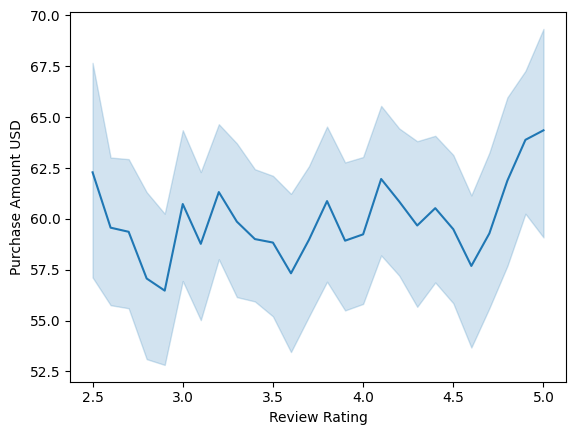

In [50]:
# additional analysis :
# Purchase amount (USD) and Review Rating
sns.lineplot(x="Review Rating", y="Purchase Amount USD", data=df)

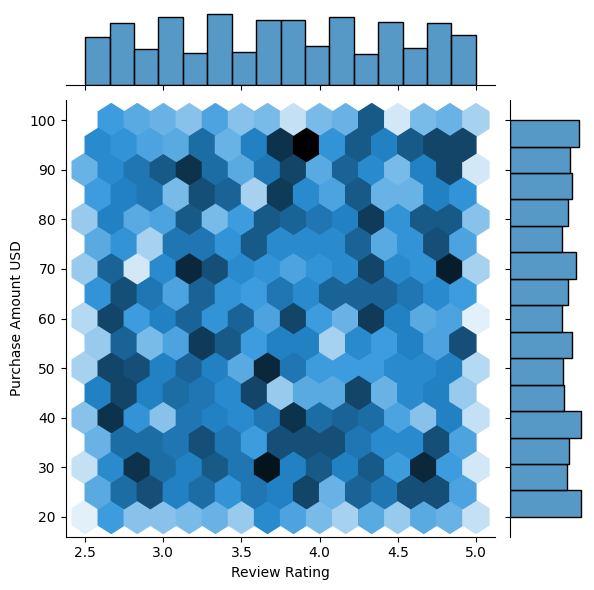

In [51]:
sns.jointplot(x="Review Rating", y="Purchase Amount USD", data=df, kind="hex")

In [58]:
pip install yellowbrick

      Age  Purchase Amount USD  Review Rating
0      55                   53            3.1
1      19                   64            3.1
2      50                   73            3.1
3      21                   90            3.5
4      45                   49            2.7
...   ...                  ...            ...
3895   40                   28            4.2
3896   52                   49            4.5
3897   46                   33            2.9
3898   44                   77            3.8
3899   52                   81            3.1

[3900 rows x 3 columns]


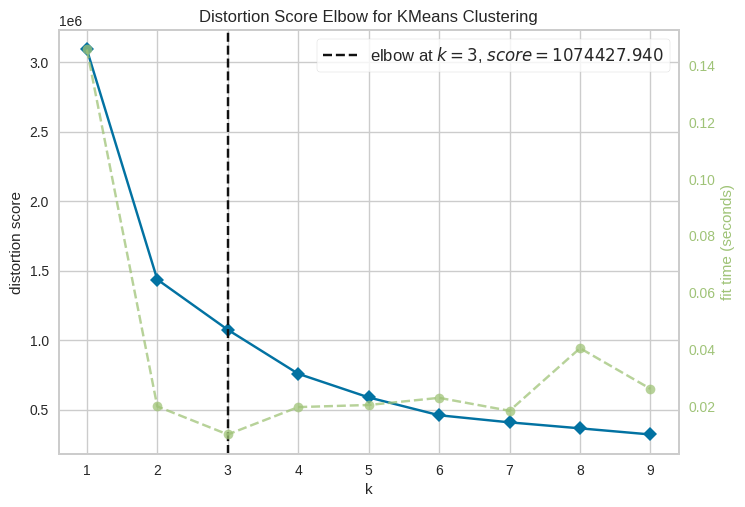

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [52]:
# K-Means Clustering :
from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
df_age_rev = df[['Age', 'Purchase Amount USD', 'Review Rating']]
print(df_age_rev)

model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,10)).fit(df_age_rev)
visualizer.show()

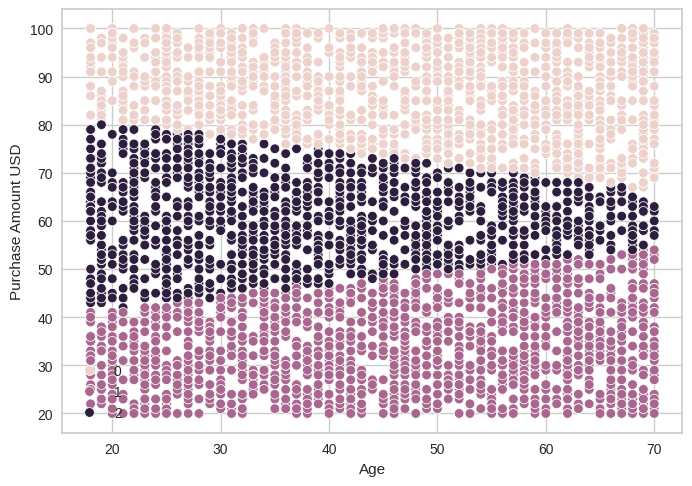

In [53]:
# Kmeans
kmeans = KMeans(n_clusters=3, init='k-means++', random_state=0).fit(df_age_rev)

sns.scatterplot(data=df_age_rev, x="Age", y="Purchase Amount USD", hue=kmeans.labels_)

plt.show()

           Age  Purchase Amount USD  Review Rating
0     0.718913            -0.285629      -0.907584
1    -1.648629             0.178852      -0.907584
2     0.390088             0.558882      -0.907584
3    -1.517099             1.276716      -0.349027
4     0.061263            -0.454531      -1.466141
...        ...                  ...            ...
3895 -0.267563            -1.341267       0.628448
3896  0.521618            -0.454531       1.047366
3897  0.127028            -1.130139      -1.186862
3898 -0.004502             0.727784       0.069891
3899  0.521618             0.896686      -0.907584

[3900 rows x 3 columns]


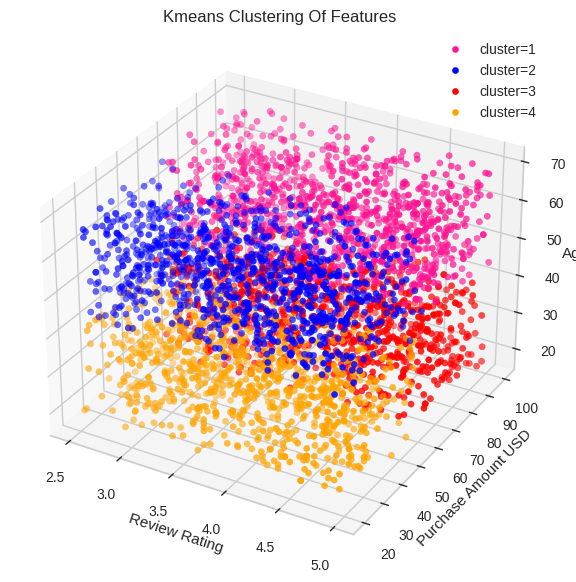

In [54]:
# kmeans
scaler = StandardScaler()
dd = scaler.fit_transform(df_age_rev)
dd = pd.DataFrame(dd, columns=['Age', 'Purchase Amount USD', 'Review Rating'])
print(dd)
kmeans3d = KMeans(n_clusters = 4, init = 'k-means++',  random_state=42)
y = kmeans3d.fit_predict(df_age_rev)
df_age_rev['cluster'] = y

color_list = ['deeppink', 'blue', 'red', 'orange', 'darkviolet', 'brown']
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in range(df_age_rev.cluster.nunique()):
    label = "cluster=" + str(i+1)
    ax.scatter3D(df_age_rev[df_age_rev.cluster==i]['Review Rating'], df_age_rev[df_age_rev.cluster==i]['Purchase Amount USD'], df_age_rev[df_age_rev.cluster==i]['Age'], c=color_list[i], label=label)

ax.set_xlabel('Review Rating')
ax.set_ylabel('Purchase Amount USD')
ax.set_zlabel('Age')
plt.legend()
plt.title("Kmeans Clustering Of Features")
plt.show()

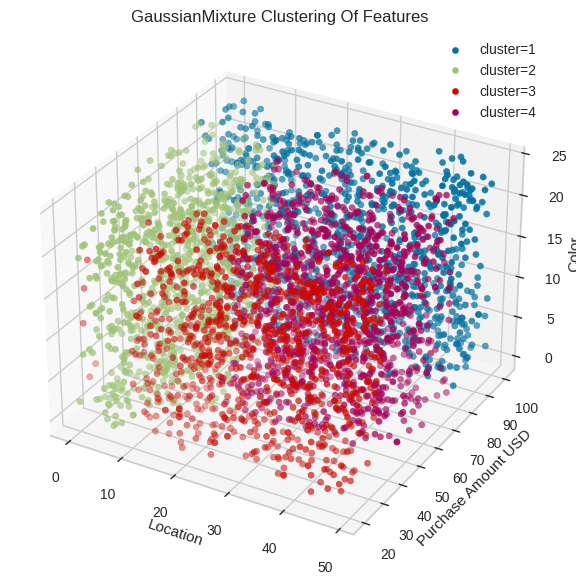

In [55]:
ddd = encoded_df2[["Location", "Color", "Purchase Amount USD"]]
from sklearn.mixture import GaussianMixture

model = GaussianMixture(n_components = 4)
model.fit(ddd)
y = model.predict(ddd)

encoded_df2['cluster'] = y

color_list = ['deeppink', 'blue', 'red', 'orange', 'darkviolet', 'brown']
fig = plt.figure(figsize = (10, 7))
ax = plt.axes(projection ="3d")

for i in range(encoded_df2.cluster.nunique()):
    label = "cluster=" + str(i+1)
    ax.scatter3D(encoded_df2[encoded_df2.cluster==i]["Location"], encoded_df2[encoded_df2.cluster==i]['Purchase Amount USD'], encoded_df2[encoded_df2.cluster==i]["Color"], label=label)

ax.set_xlabel("Location")
ax.set_ylabel('Purchase Amount USD')
ax.set_zlabel("Color")
plt.legend()
plt.title("GaussianMixture Clustering Of Features")
plt.show()